DÉTECTION DE CHURN DANS LE SECTEUR BANCAIRE

OBJECTIVE:
----------
Develop a high-performance churn prediction system using:
- Fine-tuning with RandomizedSearchCV
- Ensemble Learning (Stacking and Voting)
- Multi-level comparison (Baseline vs Tuned vs Ensemble)

MODELS IMPLEMENTED:
-------------------
- Random Forest
- XGBoost
- LightGBM
- CatBoost
- Stacking Ensemble
- Voting Ensemble

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

1. CHARGEMENT ET APERÇU DES DONNÉES

In [3]:
# Charger les données
df = pd.read_csv('../data/bank_customer_churn.csv')

In [4]:
print(f"\n📊 Dimensions du dataset: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"💾 Taille mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


📊 Dimensions du dataset: 115,640 lignes × 25 colonnes
💾 Taille mémoire: 112.04 MB


In [5]:
print("Premières lignes du dataset:")

df.head()

Premières lignes du dataset:


,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,Income,Education Level,Address,Contact Information,Customer Tenure,Customer Segment,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints
0,1,83ef0b54-35f6-4f84-af58-5653ac0c0dc4,Smith,Troy,1987-08-29,Male,Divorced,3,Information systems manager,77710.14,High School,"26644 Diaz Viaduct\nNorth Jessicaville, VI 14852",001-301-934-3058x0825,30,Retail,Phone,397,24,41959.74,0,NaN,NaN,211359.05,1,0
1,2,009f115a-e5ca-4cf4-97d6-530140545e4e,Sullivan,Katrina,2000-02-07,Female,Married,1,Charity fundraiser,58209.87,High School,"5642 Rachel Pass Suite 320\nPort Peggy, RI 75805",+1-581-683-4267,27,SME,Email,665,10,8916.67,0,NaN,NaN,30624.76,4,1
2,3,66309fd3-5009-44d3-a3f7-1657c869d573,Fuller,Henry,1954-02-03,Female,Single,1,Television production assistant,9794.01,High School,00025 Brittany Flats Apt. 543\nNew Amandaborou...,9753900004,14,Retail,Email,715,21,43270.54,0,NaN,NaN,111956.61,2,6
3,4,b02a30df-1a5f-4087-8075-2a35432da641,Young,Antonio,1991-01-15,Female,Divorced,5,Agricultural engineer,15088.98,High School,Unit 3386 Box 0088\nDPO AE 71940,+1-928-477-2856x660,23,Corporate,Phone,747,17,17887.65,0,NaN,NaN,201187.61,1,0
4,5,0d932e5b-bb3a-4104-8c83-f84270f7f2ea,Andersen,John,1992-04-08,Female,Divorced,2,"Teacher, early years/pre",60726.56,Master's,"0120 Leslie River\nWest Lindseychester, MN 98290",204.515.2388,22,Corporate,Email,549,25,32686.84,0,NaN,NaN,60391.24,5,6


In [6]:
print("Informations sur les colonnes:")

print(df.info())

Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115640 entries, 0 to 115639
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   RowNumber                        115640 non-null  int64  
 1   CustomerId                       115640 non-null  object 
 2   Surname                          115640 non-null  object 
 3   First Name                       115640 non-null  object 
 4   Date of Birth                    115640 non-null  object 
 5   Gender                           115640 non-null  object 
 6   Marital Status                   115640 non-null  object 
 7   Number of Dependents             115640 non-null  int64  
 8   Occupation                       115640 non-null  object 
 9   Income                           115640 non-null  float64
 10  Education Level                  115640 non-null  object 
 11  Address                          1

2. PRÉSENTATION ET DESCRIPTION DÉTAILLÉE DES FEATURES

In [7]:
features_description = {
    'RowNumber': {
        'Type': 'Integer',
        'Description': 'Index de la ligne dans le dataset',
        'Utilité': 'Utilisé uniquement pour l’identification, aucune valeur prédictive'
    },
    'CustomerId': {
        'Type': 'String (UUID)',
        'Description': 'Identifiant unique du client',
        'Utilité': 'Identification du client; pas utilisé directement pour la prédiction'
    },
    'Surname': {
        'Type': 'String',
        'Description': 'Nom de famille du client',
        'Utilité': 'Faible pertinence prédictive; parfois utilisé pour études démographiques'
    },
    'First Name': {
        'Type': 'String',
        'Description': 'Prénom du client',
        'Utilité': 'Identification; généralement supprimé car non significatif'
    },
    'Date of Birth': {
        'Type': 'Date',
        'Description': 'Date de naissance du client',
        'Utilité': 'Permet de calculer l’âge, feature très importante en churn prediction'
    },
    'Gender': {
        'Type': 'Categorical (Male/Female)',
        'Description': 'Genre du client',
        'Utilité': 'Analyse démographique et segmentation'
    },
    'Marital Status': {
        'Type': 'Categorical',
        'Description': 'Statut marital (Single, Married, Divorced...)',
        'Utilité': 'Segmentation sociologique; impact possible sur le risque de churn'
    },
    'Number of Dependents': {
        'Type': 'Integer',
        'Description': 'Nombre de personnes à charge du client',
        'Utilité': 'Indique le niveau de charge familiale, peut influencer la stabilité financière'
    },
    'Occupation': {
        'Type': 'String',
        'Description': 'Profession du client',
        'Utilité': 'Analyse socio-professionnelle, corrélée au revenu et au risque de churn'
    },
    'Income': {
        'Type': 'Float',
        'Description': 'Revenu annuel estimé du client',
        'Utilité': 'Variable clé pour estimer la solvabilité et la probabilité de churn'
    },
    'Education Level': {
        'Type': 'Categorical',
        'Description': 'Niveau éducatif du client (High School, Bachelor, Master...)',
        'Utilité': 'Segmentation sociologique; peut influencer le comportement financier'
    },
    'Address': {
        'Type': 'String',
        'Description': 'Adresse complète du client',
        'Utilité': 'Peu utilisé en modélisation; possible extraction de région ou zone'
    },
    'Contact Information': {
        'Type': 'String',
        'Description': 'Numéro de téléphone ou contact du client',
        'Utilité': 'Utilisé pour la communication; pas utile pour un modèle prédictif'
    },
    'Customer Tenure': {
        'Type': 'Integer (years)',
        'Description': 'Nombre d’années depuis que le client est dans la banque',
        'Utilité': 'Variable très importante: les nouveaux clients churnent plus souvent'
    },
    'Customer Segment': {
        'Type': 'Categorical',
        'Description': 'Segment du client (Retail, SME, Corporate...)',
        'Utilité': 'Segmentation commerciale essentielle pour analyser le churn'
    },
    'Preferred Communication Channel': {
        'Type': 'Categorical',
        'Description': 'Canal préféré pour communiquer (Email, Phone...)',
        'Utilité': 'Comprendre les préférences du client; utile pour la rétention'
    },
    'Credit Score': {
        'Type': 'Integer',
        'Description': 'Score de crédit du client',
        'Utilité': 'Indicateur clé de risque financier; impact direct sur le churn'
    },
    'Credit History Length': {
        'Type': 'Integer (years)',
        'Description': 'Ancienneté de l’historique de crédit',
        'Utilité': 'Mesure de stabilité financière; aide à estimer le risque de churn'
    },
    'Outstanding Loans': {
        'Type': 'Float',
        'Description': 'Montant total des prêts en cours du client',
        'Utilité': 'Indique l’endettement; corrélé à la probabilité de churn'
    },
    'Churn Flag': {
        'Type': 'Binary (0/1)',
        'Description': 'Variable cible: 1=Client churned, 0=Client actif',
        'Utilité': 'Label utilisé pour l’apprentissage supervisé'
    },
    'Churn Reason': {
        'Type': 'String',
        'Description': 'Raison du churn si le client a quitté la banque',
        'Utilité': 'Analyse qualitative; non utilisable comme feature en prédiction'
    },
    'Churn Date': {
        'Type': 'Date',
        'Description': 'Date à laquelle le client a quitté la banque',
        'Utilité': 'Analyse temporelle du churn; exclue du modèle'
    },
    'Balance': {
        'Type': 'Float',
        'Description': 'Solde actuel du compte bancaire du client',
        'Utilité': 'Variable très importante: solvabilité et comportement bancaire'
    },
    'NumOfProducts': {
        'Type': 'Integer',
        'Description': 'Nombre de produits bancaires utilisés',
        'Utilité': 'Plus un client utilise de services, moins il est susceptible de churn'
    },
    'NumComplaints': {
        'Type': 'Integer',
        'Description': 'Nombre total de réclamations effectuées par le client',
        'Utilité': 'Indicateur très fort de churn potentiel'
    }
}

# Affichage formaté
for feature, info in features_description.items():
    print(f"\n📌 {feature}")
    print(f"   Type: {info['Type']}")
    print(f"   Description: {info['Description']}")
    print(f"   Utilité: {info['Utilité']}")



📌 RowNumber
   Type: Integer
   Description: Index de la ligne dans le dataset
   Utilité: Utilisé uniquement pour l’identification, aucune valeur prédictive

📌 CustomerId
   Type: String (UUID)
   Description: Identifiant unique du client
   Utilité: Identification du client; pas utilisé directement pour la prédiction

📌 Surname
   Type: String
   Description: Nom de famille du client
   Utilité: Faible pertinence prédictive; parfois utilisé pour études démographiques

📌 First Name
   Type: String
   Description: Prénom du client
   Utilité: Identification; généralement supprimé car non significatif

📌 Date of Birth
   Type: Date
   Description: Date de naissance du client
   Utilité: Permet de calculer l’âge, feature très importante en churn prediction

📌 Gender
   Type: Categorical (Male/Female)
   Description: Genre du client
   Utilité: Analyse démographique et segmentation

📌 Marital Status
   Type: Categorical
   Description: Statut marital (Single, Married, Divorced...)
   Uti

3. STATISTIQUES DESCRIPTIVES GLOBALES

In [8]:
print("Variables numériques:")

df.describe().T

Variables numériques:


,count,mean,std,min,25%,50%,75%,max
RowNumber,115640.0,57820.500000,33382.536902,1.00,28910.750,57820.500,86730.2500,115640.00
Number of Dependents,115640.0,2.502923,1.707249,0.00,1.000,3.000,4.0000,5.00
Income,115640.0,52641.363046,27429.756390,5000.96,28857.070,52658.110,76364.1575,99999.51
Customer Tenure,115640.0,15.490591,8.654217,1.00,8.000,15.000,23.0000,30.00
Credit Score,115640.0,574.299775,159.067499,300.00,436.000,574.000,712.0000,850.00
Credit History Length,115640.0,15.546602,8.654630,1.00,8.000,16.000,23.0000,30.00
Outstanding Loans,115640.0,25502.731792,14127.859827,1000.43,13226.060,25505.285,37742.2500,49999.69
Churn Flag,115640.0,0.121878,0.327147,0.00,0.000,0.000,0.0000,1.00
Balance,115640.0,124639.209748,72210.476638,1.06,61991.915,124505.890,187122.9225,249998.91
NumOfProducts,115640.0,2.999274,1.411361,1.00,2.000,3.000,4.0000,5.00


In [9]:
print("Variables catégorielles:")

categorical_cols = ['Gender','Marital Status','Occupation','Education Level','Customer Segment', 'Preferred Communication Channel', 'Churn Reason']
for col in categorical_cols:
    print(df[col].value_counts().head(10))
    print()

Variables catégorielles:
Gender
Female    57830
Male      57810
Name: count, dtype: int64

Marital Status
Single      38684
Divorced    38539
Married     38417
Name: count, dtype: int64

Occupation
Engineer, materials                    222
Biochemist, clinical                   218
Contractor                             217
Surveyor, commercial/residential       215
Surveyor, building                     215
Quarry manager                         214
Pharmacist, hospital                   214
Surveyor, land/geomatics               214
Ambulance person                       213
Engineer, broadcasting (operations)    213
Name: count, dtype: int64

Education Level
Master's       28970
Diploma        28950
High School    28868
Bachelor's     28852
Name: count, dtype: int64

Customer Segment
SME          38903
Corporate    38606
Retail       38131
Name: count, dtype: int64

Preferred Communication Channel
Email    58044
Phone    57596
Name: count, dtype: int64

Churn Reason
Service Issues 

4. ANALYSE DE LA VARIABLE CIBLE (Churn Flag)

In [10]:
churn_counts = df['Churn Flag'].value_counts()
churn_percentage = df['Churn Flag'].value_counts(normalize=True) * 100

In [11]:
print(f"\n🎯 Distribution des churns:")
print(f"   Nbr of churn: {churn_counts[1]:,} ({churn_percentage[1]:.2f}%)")
print(f"   Nbr of non churn: {churn_counts[0]:,} ({churn_percentage[0]:.2f}%)")
print(f"   Ratio non churn/churn: 1:{int(churn_counts[0]/churn_counts[1])}")
print(f"\n⚠️  Dataset DÉSÉQUILIBRÉ - Techniques de rééquilibrage nécessaires!")


🎯 Distribution des churns:
   Nbr of churn: 14,094 (12.19%)
   Nbr of non churn: 101,546 (87.81%)
   Ratio non churn/churn: 1:7

⚠️  Dataset DÉSÉQUILIBRÉ - Techniques de rééquilibrage nécessaires!


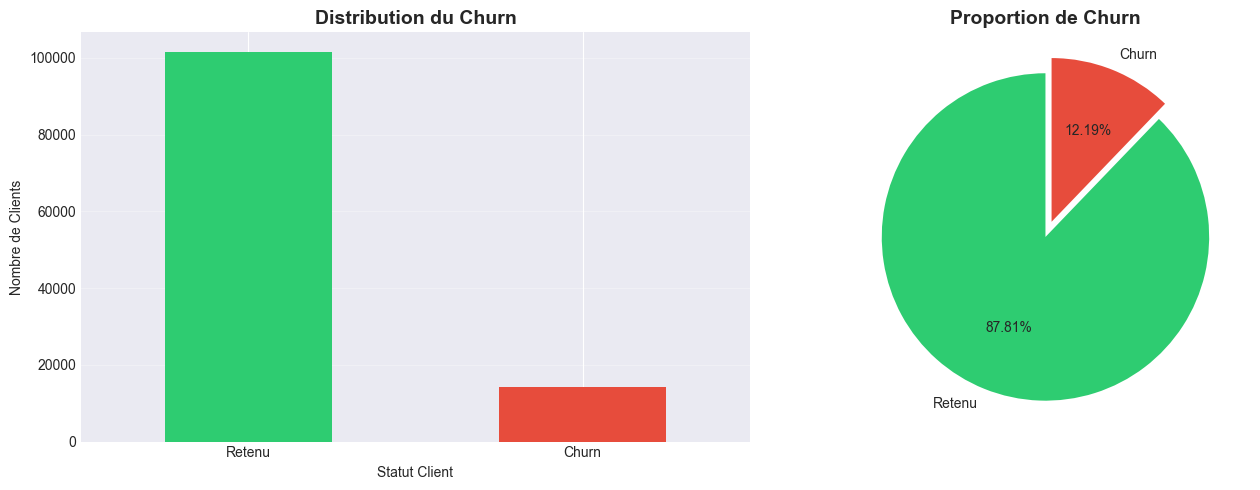

In [12]:
import os
os.makedirs('./png', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Comptage
df['Churn Flag'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribution du Churn', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Statut Client')
axes[0].set_ylabel('Nombre de Clients')
axes[0].set_xticklabels(['Retenu', 'Churn'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Graphique 2: Pourcentage
churn_counts = df['Churn Flag'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(churn_counts, labels=['Retenu', 'Churn'], autopct='%1.2f%%',
            colors=colors, startangle=90, explode=(0, 0.1))
axes[1].set_title('Proportion de Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./png/churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

5. ANALYSE DES VALEURS MANQUANTES

In [13]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Colonnes': missing_values.index,
    'Valeurs Manquantes': missing_values.values,
    'Pourcentage (%)': missing_percentage.values
})
missing_df = missing_df[missing_df['Valeurs Manquantes'] > 0].sort_values('Valeurs Manquantes', ascending=False)
if len(missing_df) > 0:
    print("\n⚠️  Valeurs manquantes détectées:")
    print(missing_df.to_string(index=False))
else:
    print("\n✅ Aucune valeur manquante détectée dans le dataset!")


⚠️  Valeurs manquantes détectées:
    Colonnes  Valeurs Manquantes  Pourcentage (%)
Churn Reason              101546        87.812176
  Churn Date              101546        87.812176


6. FEATURE ENGINEERING - CRÉATION DE NOUVELLES VARIABLES

In [14]:
# AGE
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], dayfirst=True)
current_year = datetime.now().year
df['Age'] = current_year - df['Date of Birth'].dt.year

In [15]:
# CATÉGORIE DU CREDIT SCORE
def credit_score_category(score):
    if score < 580:
        return 'Poor'
    elif score < 670:
        return 'Fair'
    elif score < 740:
        return 'Good'
    elif score < 800:
        return 'Very Good'
    else:
        return 'Excellent'

df['Credit Score Category'] = df['Credit Score'].apply(credit_score_category)

In [16]:
# DEBT-TO-INCOME RATIO (DTI)
df['DTI'] = df['Outstanding Loans'] / df['Income']

In [17]:
# CATÉGORIE DE L’ANCIENNETÉ (TENURE)
def tenure_category(tenure):
    if tenure < 1:
        return 'New'
    elif tenure < 5:
        return 'Mid'
    else:
        return 'Loyal'

df['Tenure Category'] = df['Customer Tenure'].apply(tenure_category)

In [18]:
# Afficher le dataset avec les nouvelles colonnes
display(df.head())

,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,Income,Education Level,Address,Contact Information,Customer Tenure,Customer Segment,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints,Age,Credit Score Category,DTI,Tenure Category
0,1,83ef0b54-35f6-4f84-af58-5653ac0c0dc4,Smith,Troy,1987-08-29,Male,Divorced,3,Information systems manager,77710.14,High School,"26644 Diaz Viaduct\nNorth Jessicaville, VI 14852",001-301-934-3058x0825,30,Retail,Phone,397,24,41959.74,0,NaN,NaN,211359.05,1,0,38,Poor,0.539952,Loyal
1,2,009f115a-e5ca-4cf4-97d6-530140545e4e,Sullivan,Katrina,2000-02-07,Female,Married,1,Charity fundraiser,58209.87,High School,"5642 Rachel Pass Suite 320\nPort Peggy, RI 75805",+1-581-683-4267,27,SME,Email,665,10,8916.67,0,NaN,NaN,30624.76,4,1,25,Fair,0.153181,Loyal
2,3,66309fd3-5009-44d3-a3f7-1657c869d573,Fuller,Henry,1954-02-03,Female,Single,1,Television production assistant,9794.01,High School,00025 Brittany Flats Apt. 543\nNew Amandaborou...,9753900004,14,Retail,Email,715,21,43270.54,0,NaN,NaN,111956.61,2,6,71,Good,4.418062,Loyal
3,4,b02a30df-1a5f-4087-8075-2a35432da641,Young,Antonio,1991-01-15,Female,Divorced,5,Agricultural engineer,15088.98,High School,Unit 3386 Box 0088\nDPO AE 71940,+1-928-477-2856x660,23,Corporate,Phone,747,17,17887.65,0,NaN,NaN,201187.61,1,0,34,Very Good,1.185478,Loyal
4,5,0d932e5b-bb3a-4104-8c83-f84270f7f2ea,Andersen,John,1992-04-08,Female,Divorced,2,"Teacher, early years/pre",60726.56,Master's,"0120 Leslie River\nWest Lindseychester, MN 98290",204.515.2388,22,Corporate,Email,549,25,32686.84,0,NaN,NaN,60391.24,5,6,33,Poor,0.538263,Loyal


In [19]:
print("\n✅ Nouvelles features créées:")
new_features = ['Age',  'Credit Score Category', 'DTI', 'Tenure Category']
for feat in new_features:
    print(f"   • {feat}")


✅ Nouvelles features créées:
   • Age
   • Credit Score Category
   • DTI
   • Tenure Category


In [ ]:
# Save the new dataset
df.to_csv("../data/dataset_with_features.csv", index=False)
print("✔ Dataset saved as dataset_with_features.csv")

✔ Dataset saved as dataset_with_features.csv


ANALYSE DE CREDIT SCORE

In [21]:
print("Statistiques des scores par type:")

df.groupby('Churn Flag')['Credit Score'].describe()

Statistiques des scores par type:


,count,mean,std,min,25%,50%,75%,max
Churn Flag,,,,,,,,
0,101546.0,585.132738,158.214328,300.0,450.0,590.0,723.0,850.0
1,14094.0,496.249255,142.537108,300.0,374.0,469.0,596.0,850.0


In [22]:
Churn_credit_score_amounts = df[df['Churn Flag'] == 1]['Credit Score']
Retention_credit_score_amounts = df[df['Churn Flag'] == 0]['Credit Score']
print(f"\n💰 Montant moyen:")
print(f"   Retention: ${Retention_credit_score_amounts.mean():.2f}")
print(f"   Churn: ${Churn_credit_score_amounts.mean():.2f}")
print(f"   Différence: ${abs(Churn_credit_score_amounts.mean() - Retention_credit_score_amounts.mean()):.2f}")


💰 Montant moyen:
   Retention: $585.13
   Churn: $496.25
   Différence: $88.88


# VISUALISATIONS DES CREDIT SCORES

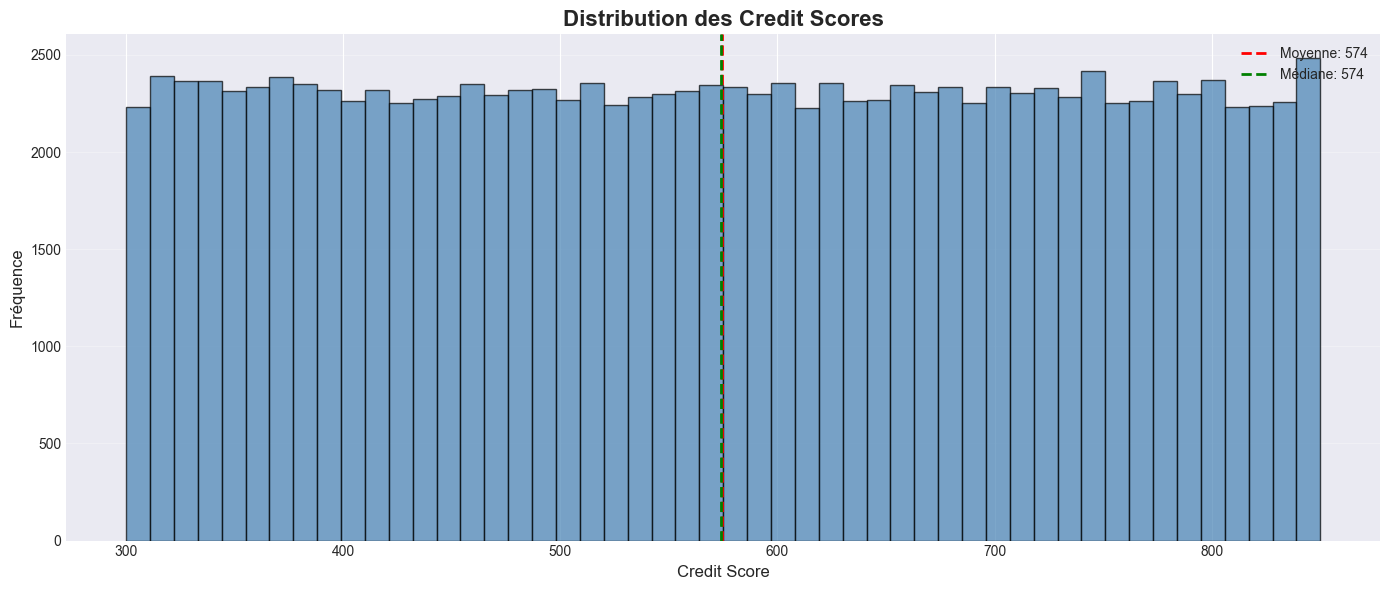


Statistiques des Credit Scores:
Moyenne: 574.30
Médiane: 574.00
Min: 300
Max: 850
Écart-type: 159.07


In [23]:
# Distribution des Credit Scores
fig, ax = plt.subplots(figsize=(14, 6))

# Histogram avec KDE
ax.hist(df['Credit Score'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax.set_title('Distribution des Credit Scores', fontsize=16, fontweight='bold')
ax.set_xlabel('Credit Score', fontsize=12)
ax.set_ylabel('Fréquence', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Ajouter des statistiques
mean_score = df['Credit Score'].mean()
median_score = df['Credit Score'].median()
ax.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_score:.0f}')
ax.axvline(median_score, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_score:.0f}')
ax.legend()

plt.tight_layout()
plt.savefig('./png/credit_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nStatistiques des Credit Scores:")
print(f"Moyenne: {mean_score:.2f}")
print(f"Médiane: {median_score:.2f}")
print(f"Min: {df['Credit Score'].min()}")
print(f"Max: {df['Credit Score'].max()}")
print(f"Écart-type: {df['Credit Score'].std():.2f}")

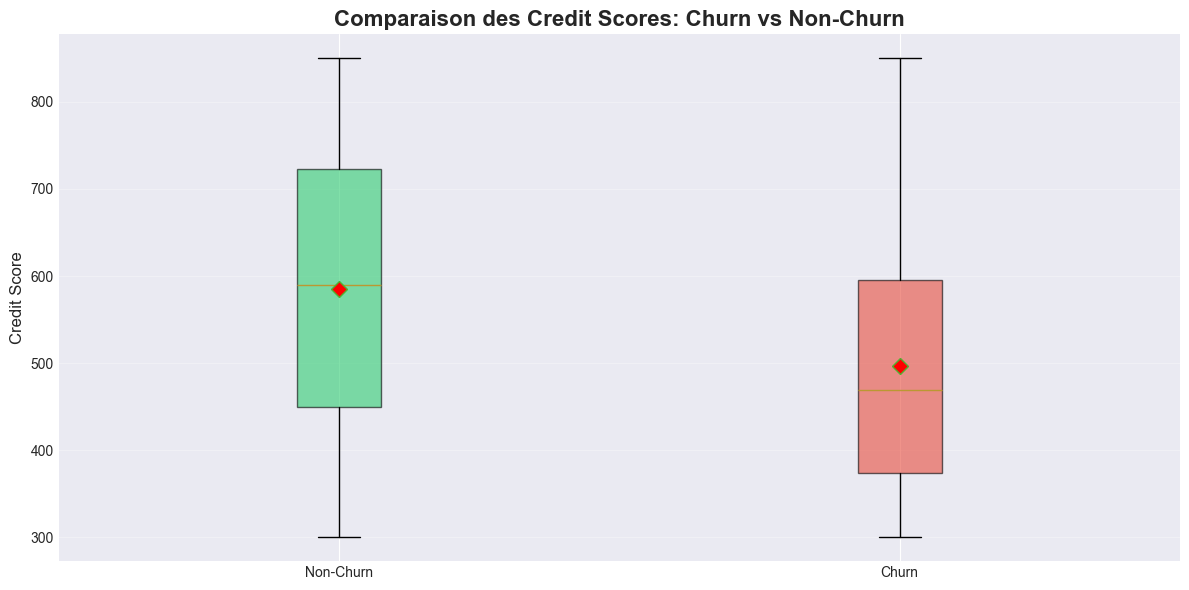


Statistiques Credit Score - Non-Churn:
Moyenne: 585.13
Médiane: 590.00

Statistiques Credit Score - Churn:
Moyenne: 496.25
Médiane: 469.00


In [24]:
# Boxplot comparatif: Credit Score par Churn Flag
fig, ax = plt.subplots(figsize=(12, 6))

# Préparer les données
churn_data = df[df['Churn Flag'] == 1]['Credit Score']
no_churn_data = df[df['Churn Flag'] == 0]['Credit Score']

# Créer le boxplot
bp = ax.boxplot([no_churn_data, churn_data], 
                 labels=['Non-Churn', 'Churn'],
                 patch_artist=True,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Colorer les boîtes
colors = ['#2ecc71', '#e74c3c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_title('Comparaison des Credit Scores: Churn vs Non-Churn', fontsize=16, fontweight='bold')
ax.set_ylabel('Credit Score', fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./png/credit_score_boxplot_churn.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistiques comparatives
print(f"\nStatistiques Credit Score - Non-Churn:")
print(f"Moyenne: {no_churn_data.mean():.2f}")
print(f"Médiane: {no_churn_data.median():.2f}")
print(f"\nStatistiques Credit Score - Churn:")
print(f"Moyenne: {churn_data.mean():.2f}")
print(f"Médiane: {churn_data.median():.2f}")

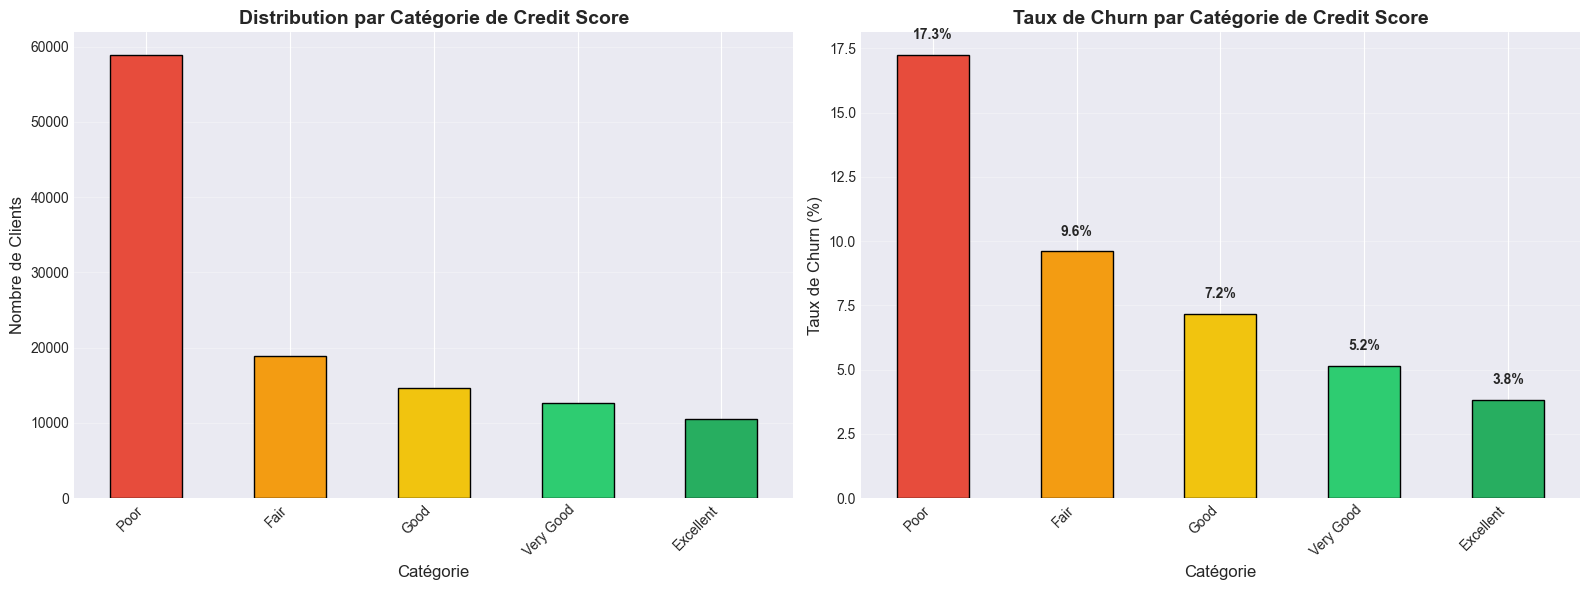


Distribution par catégorie:
Poor        :  58937 clients (50.97%) - Taux de churn: 17.26%
Fair        :  18863 clients (16.31%) - Taux de churn:  9.60%
Good        :  14659 clients (12.68%) - Taux de churn:  7.18%
Very Good   :  12679 clients (10.96%) - Taux de churn:  5.15%
Excellent   :  10502 clients ( 9.08%) - Taux de churn:  3.84%


In [25]:
# Distribution par catégorie de Credit Score
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Count plot
category_counts = df['Credit Score Category'].value_counts()
category_order = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
category_counts = category_counts.reindex(category_order, fill_value=0)

colors_cat = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']
category_counts.plot(kind='bar', ax=axes[0], color=colors_cat, edgecolor='black')
axes[0].set_title('Distribution par Catégorie de Credit Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Catégorie', fontsize=12)
axes[0].set_ylabel('Nombre de Clients', fontsize=12)
axes[0].set_xticklabels(category_order, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Graphique 2: Taux de churn par catégorie
churn_by_category = df.groupby('Credit Score Category')['Churn Flag'].mean() * 100
churn_by_category = churn_by_category.reindex(category_order, fill_value=0)

churn_by_category.plot(kind='bar', ax=axes[1], color=colors_cat, edgecolor='black')
axes[1].set_title('Taux de Churn par Catégorie de Credit Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Catégorie', fontsize=12)
axes[1].set_ylabel('Taux de Churn (%)', fontsize=12)
axes[1].set_xticklabels(category_order, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, v in enumerate(churn_by_category):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('./png/credit_score_category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDistribution par catégorie:")
for cat in category_order:
    count = category_counts[cat]
    pct = (count / len(df)) * 100
    churn_rate = churn_by_category[cat]
    print(f"{cat:12s}: {count:6d} clients ({pct:5.2f}%) - Taux de churn: {churn_rate:5.2f}%")

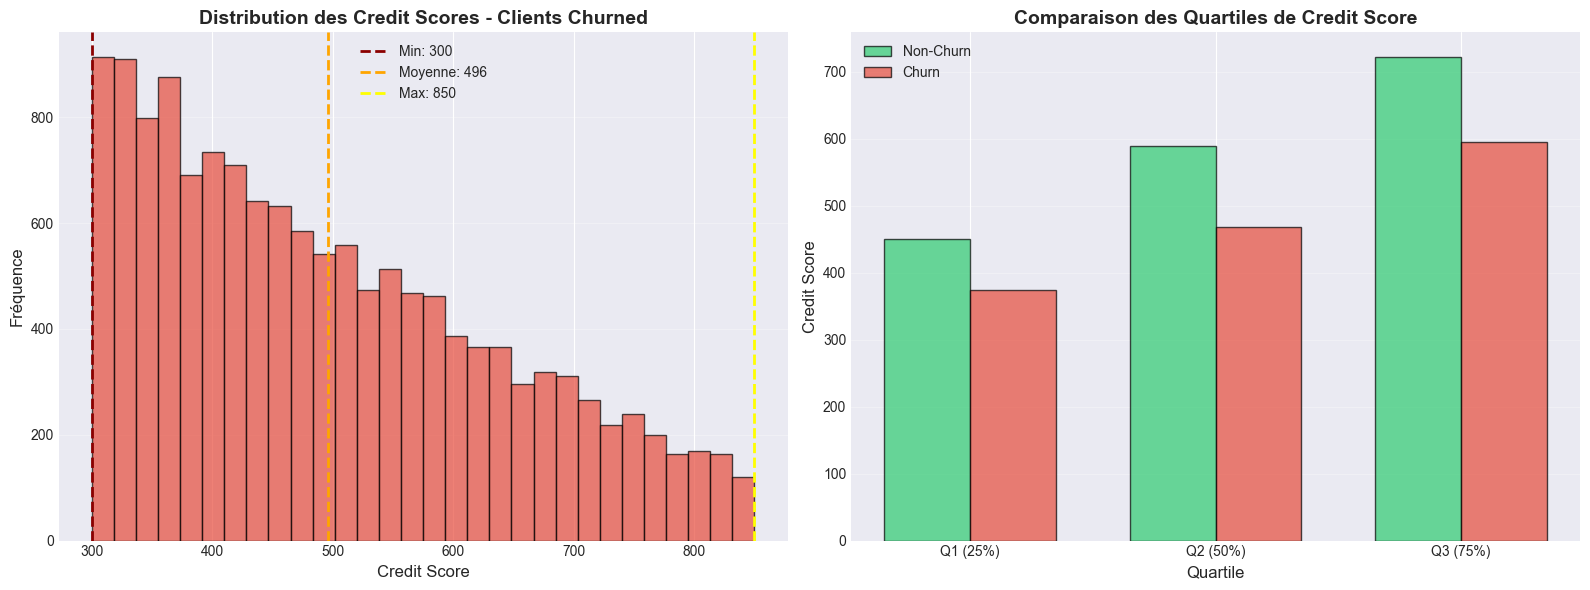


ANALYSE DES CREDIT SCORES - CLIENTS CHURNED

Credit Score Minimum (Churn): 300
Credit Score Maximum (Churn): 850
Credit Score Moyen (Churn): 496.25
Écart-type (Churn): 142.54

Nombre de clients churned: 14,094

Quartiles (Churn):
  Q1 (25%): 374
  Q2 (50%): 469
  Q3 (75%): 596

Quartiles (Non-Churn):
  Q1 (25%): 450
  Q2 (50%): 590
  Q3 (75%): 723


In [26]:
# Analyse du Credit Score minimum pour les clients en Churn
churned_customers = df[df['Churn Flag'] == 1]
min_credit_score_churn = churned_customers['Credit Score'].min()
max_credit_score_churn = churned_customers['Credit Score'].max()
mean_credit_score_churn = churned_customers['Credit Score'].mean()

# Créer une visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Distribution des credit scores pour les churners
axes[0].hist(churned_customers['Credit Score'], bins=30, alpha=0.7, color='#e74c3c', edgecolor='black')
axes[0].axvline(min_credit_score_churn, color='darkred', linestyle='--', linewidth=2, 
                label=f'Min: {min_credit_score_churn}')
axes[0].axvline(mean_credit_score_churn, color='orange', linestyle='--', linewidth=2, 
                label=f'Moyenne: {mean_credit_score_churn:.0f}')
axes[0].axvline(max_credit_score_churn, color='yellow', linestyle='--', linewidth=2, 
                label=f'Max: {max_credit_score_churn}')
axes[0].set_title('Distribution des Credit Scores - Clients Churned', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Credit Score', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Graphique 2: Comparaison des quartiles
quartiles_churn = churned_customers['Credit Score'].quantile([0.25, 0.5, 0.75])
quartiles_no_churn = df[df['Churn Flag'] == 0]['Credit Score'].quantile([0.25, 0.5, 0.75])

x = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
width = 0.35
x_pos = range(len(x))

axes[1].bar([p - width/2 for p in x_pos], quartiles_no_churn, width, 
            label='Non-Churn', color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].bar([p + width/2 for p in x_pos], quartiles_churn, width, 
            label='Churn', color='#e74c3c', alpha=0.7, edgecolor='black')

axes[1].set_title('Comparaison des Quartiles de Credit Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Quartile', fontsize=12)
axes[1].set_ylabel('Credit Score', fontsize=12)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./png/credit_score_churn_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("ANALYSE DES CREDIT SCORES - CLIENTS CHURNED")
print("="*60)
print(f"\nCredit Score Minimum (Churn): {min_credit_score_churn}")
print(f"Credit Score Maximum (Churn): {max_credit_score_churn}")
print(f"Credit Score Moyen (Churn): {mean_credit_score_churn:.2f}")
print(f"Écart-type (Churn): {churned_customers['Credit Score'].std():.2f}")
print(f"\nNombre de clients churned: {len(churned_customers):,}")
print(f"\nQuartiles (Churn):")
print(f"  Q1 (25%): {quartiles_churn[0.25]:.0f}")
print(f"  Q2 (50%): {quartiles_churn[0.50]:.0f}")
print(f"  Q3 (75%): {quartiles_churn[0.75]:.0f}")
print(f"\nQuartiles (Non-Churn):")
print(f"  Q1 (25%): {quartiles_no_churn[0.25]:.0f}")
print(f"  Q2 (50%): {quartiles_no_churn[0.50]:.0f}")
print(f"  Q3 (75%): {quartiles_no_churn[0.75]:.0f}")
print("="*60)

ANALYSE DE L'ÂGE

In [27]:
print("Statistiques de l'âge par type:\n")

df.groupby('Churn Flag')['Age'].describe()

Statistiques de l'âge par type:



,count,mean,std,min,25%,50%,75%,max
Churn Flag,,,,,,,,
0,101546.0,47.895535,16.726793,19.0,33.0,48.0,62.0,77.0
1,14094.0,47.771250,16.624252,19.0,33.0,48.0,62.0,77.0


In [28]:
Churn_age = df[df['Churn Flag'] == 1]['Age']
Retention_age = df[df['Churn Flag'] == 0]['Age']
print(f"\n💰 Âge moyen:")
print(f"   Retention: {Retention_age.mean():.2f} ans")
print(f"   Churn: {Churn_age.mean():.2f} ans")
print(f"   Différence: {abs(Churn_age.mean() - Retention_age.mean()):.2f} ans")


💰 Âge moyen:
   Retention: 47.90 ans
   Churn: 47.77 ans
   Différence: 0.12 ans


8. ANALYSE DE L'ÂGE

In [29]:
print("Statistiques de l'âge par type:\n")

df.groupby('Churn Flag')['Age'].describe()

Statistiques de l'âge par type:



,count,mean,std,min,25%,50%,75%,max
Churn Flag,,,,,,,,
0,101546.0,47.895535,16.726793,19.0,33.0,48.0,62.0,77.0
1,14094.0,47.771250,16.624252,19.0,33.0,48.0,62.0,77.0


In [30]:
Churn_age = df[df['Churn Flag'] == 1]['Age']
Retention_age = df[df['Churn Flag'] == 0]['Age']
print(f"\n💰 Âge moyen:")
print(f"   Retention: {Retention_age.mean():.2f} ans")
print(f"   Churn: {Churn_age.mean():.2f} ans")
print(f"   Différence: {abs(Churn_age.mean() - Retention_age.mean()):.2f} ans")


💰 Âge moyen:
   Retention: 47.90 ans
   Churn: 47.77 ans
   Différence: 0.12 ans


8. ANALYSE DE L'ÂGE

10. ANALYSE NumComplaints

In [31]:
print("Statistiques du nombre de Complaints par type:\n")

df.groupby('Churn Flag')['NumComplaints'].describe()

Statistiques du nombre de Complaints par type:



,count,mean,std,min,25%,50%,75%,max
Churn Flag,,,,,,,,
0,101546.0,4.750881,3.138717,0.0,2.0,5.0,7.0,10.0
1,14094.0,6.726976,2.736019,0.0,5.0,7.0,9.0,10.0


In [32]:
Churn_complaints = df[df['Churn Flag'] == 1]['NumComplaints']
Retention_complaints = df[df['Churn Flag'] == 0]['NumComplaints']
print(f"\n📞 Nombre moyen de Complaints:")
print(f"   Retention: {Retention_complaints.mean():.2f} Complaints")
print(f"   Churn: {Churn_complaints.mean():.2f} Complaints")
print(f"   Différence: {abs(Churn_complaints.mean() - Retention_complaints.mean()):.2f} Complaints")
print(f"\n   Médiane Retention: {Retention_complaints.median():.0f}")
print(f"   Médiane Churn: {Churn_complaints.median():.0f}")


📞 Nombre moyen de Complaints:
   Retention: 4.75 Complaints
   Churn: 6.73 Complaints
   Différence: 1.98 Complaints

   Médiane Retention: 5
   Médiane Churn: 7


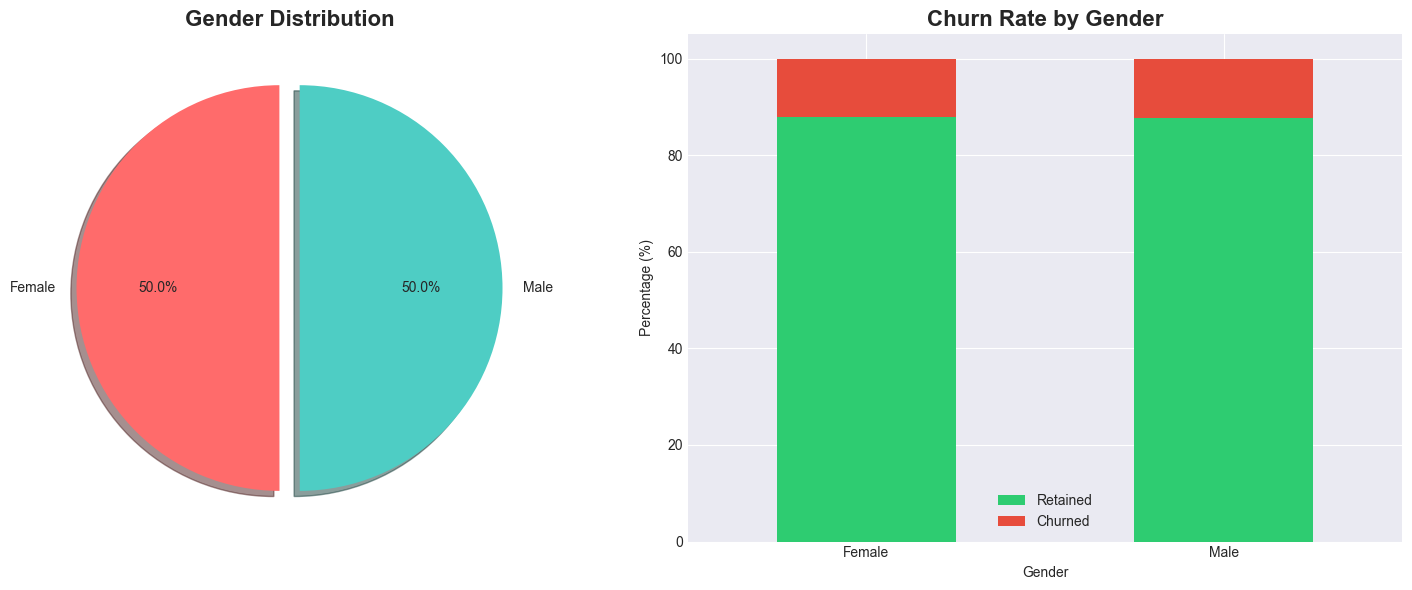

In [33]:
# ============================================================================
# 1. GENDER - Pie chart with churn overlay
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

gender_counts = df['Gender'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
explode = (0.05, 0.05)

ax1.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
        colors=colors, explode=explode, shadow=True, startangle=90)
ax1.set_title('Gender Distribution', fontsize=16, fontweight='bold')

# Gender vs Churn
gender_churn = pd.crosstab(df['Gender'], df['Churn Flag'], normalize='index') * 100
gender_churn.plot(kind='bar', stacked=True, ax=ax2, color=['#2ECC71', '#E74C3C'])
ax2.set_title('Churn Rate by Gender', fontsize=16, fontweight='bold')
ax2.set_ylabel('Percentage (%)')
ax2.set_xlabel('Gender')
ax2.legend(['Retained', 'Churned'])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

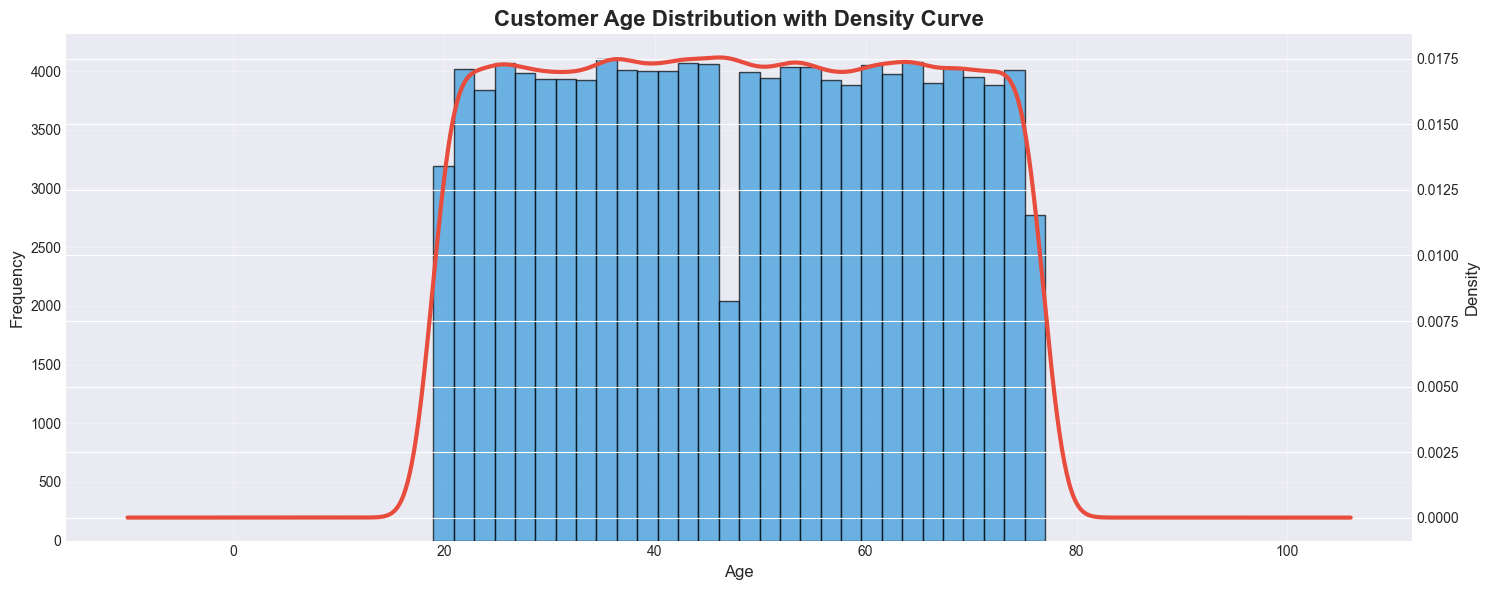

In [34]:
# ============================================================================
# 2. AGE DISTRIBUTION - Histogram with density curve
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 6))

ax.hist(df['Age'], bins=30, alpha=0.7, color='#3498DB', edgecolor='black')
ax2 = ax.twinx()
df['Age'].plot(kind='kde', ax=ax2, color='#E74C3C', linewidth=3)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax.set_title('Customer Age Distribution with Density Curve', fontsize=16, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


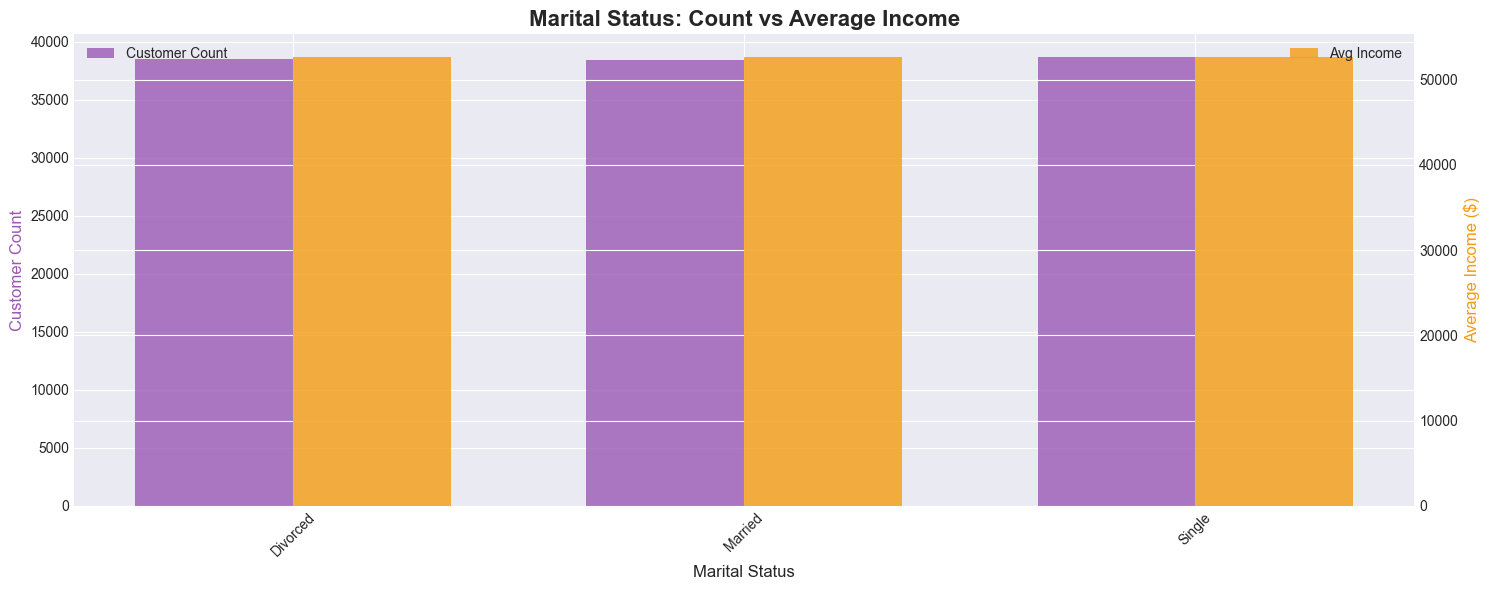

In [35]:
# ============================================================================
# 3. MARITAL STATUS - Grouped bar chart with income
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 6))

marital_income = df.groupby('Marital Status').agg({
    'Income': 'mean',
    'CustomerId': 'count'
}).round(2)

x = np.arange(len(marital_income))
width = 0.35

ax1 = ax
ax2 = ax.twinx()

bars1 = ax1.bar(x - width/2, marital_income['CustomerId'], width, 
                label='Customer Count', color='#9B59B6', alpha=0.8)
bars2 = ax2.bar(x + width/2, marital_income['Income'], width,
                label='Avg Income', color='#F39C12', alpha=0.8)

ax1.set_xlabel('Marital Status', fontsize=12)
ax1.set_ylabel('Customer Count', fontsize=12, color='#9B59B6')
ax2.set_ylabel('Average Income ($)', fontsize=12, color='#F39C12')
ax1.set_title('Marital Status: Count vs Average Income', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(marital_income.index, rotation=45)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


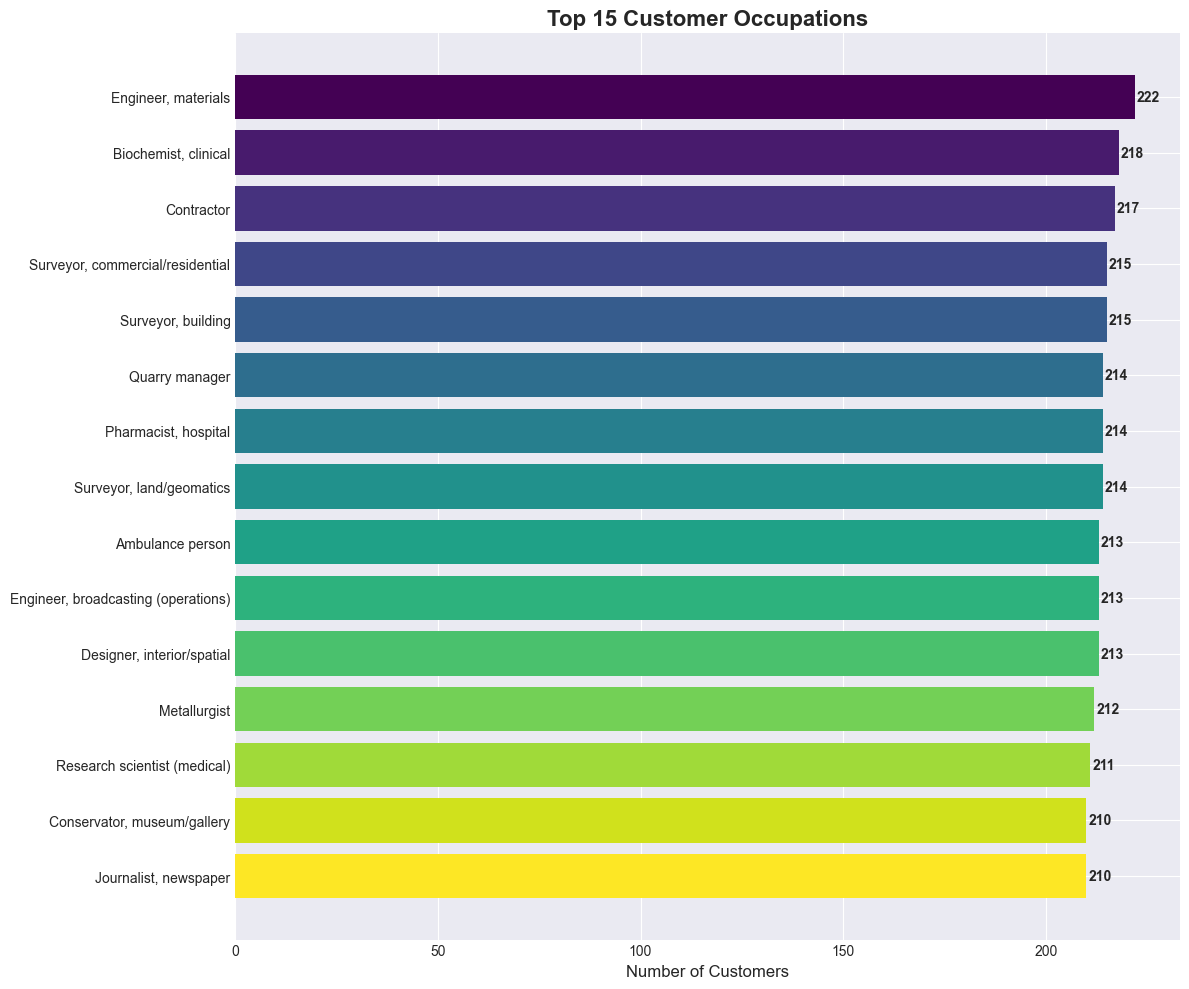

In [36]:
# ============================================================================
# 4. OCCUPATION - Horizontal bar chart (top 15)
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 10))

occupation_counts = df['Occupation'].value_counts().head(15)
colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(occupation_counts)))

bars = ax.barh(occupation_counts.index, occupation_counts.values, color=colors_gradient)
ax.set_xlabel('Number of Customers', fontsize=12)
ax.set_title('Top 15 Customer Occupations', fontsize=16, fontweight='bold')
ax.invert_yaxis()

for i, v in enumerate(occupation_counts.values):
    ax.text(v + 0.5, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

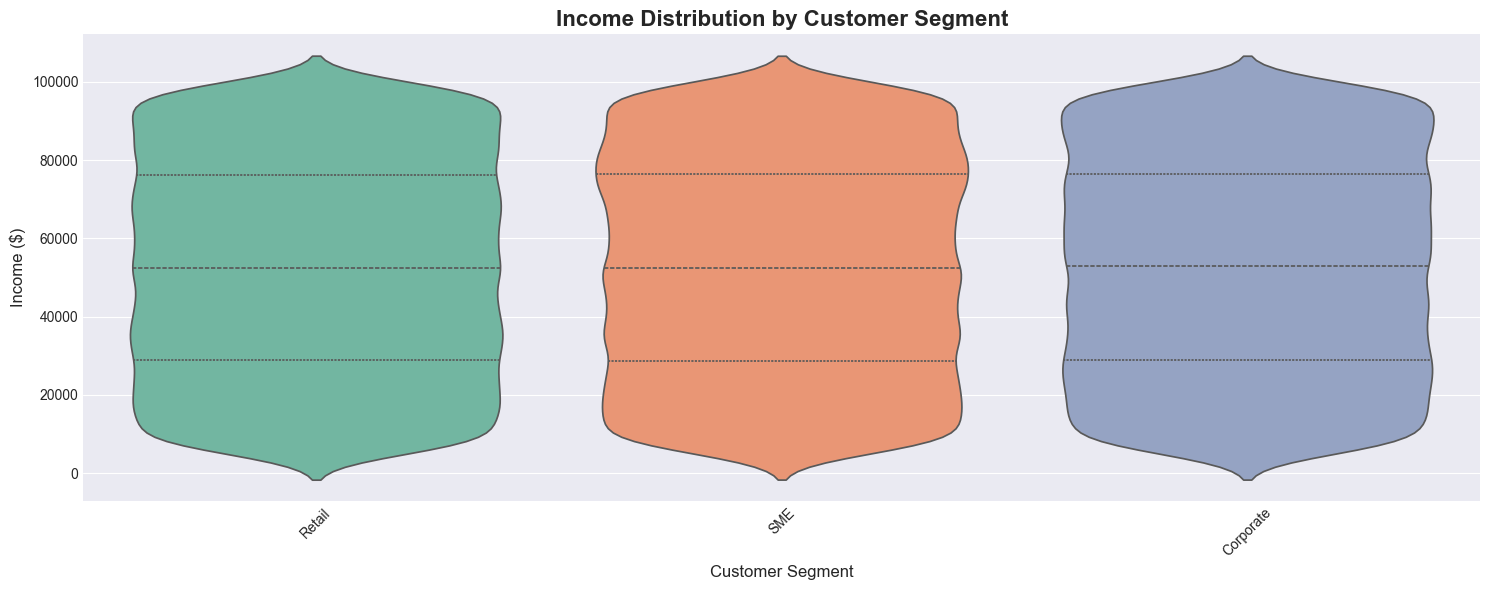

In [37]:
# ============================================================================
# 5. INCOME DISTRIBUTION - Violin plot by segment
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 6))

sns.violinplot(data=df, x='Customer Segment', y='Income', 
               palette='Set2', ax=ax, inner='quartile')
ax.set_title('Income Distribution by Customer Segment', fontsize=16, fontweight='bold')
ax.set_ylabel('Income ($)', fontsize=12)
ax.set_xlabel('Customer Segment', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

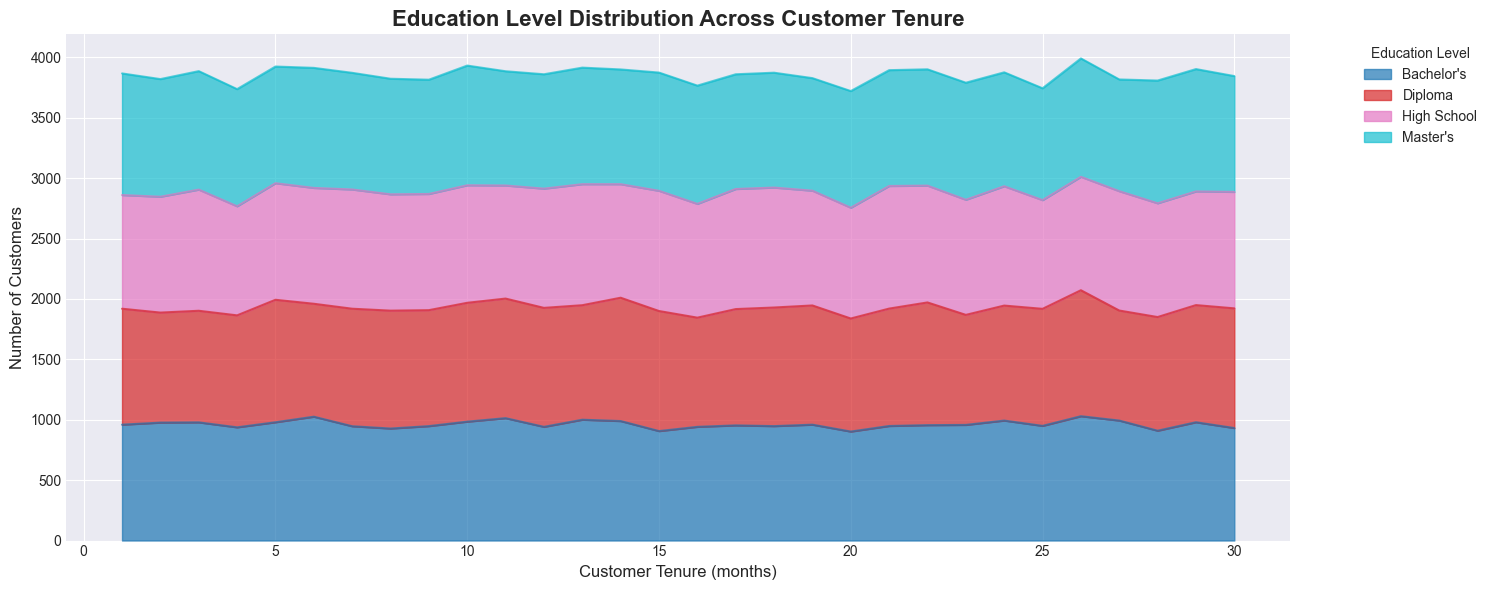

In [38]:
# ============================================================================
# 6. EDUCATION LEVEL - Stacked area chart over tenure
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 6))

edu_tenure = df.groupby(['Customer Tenure', 'Education Level']).size().unstack(fill_value=0)
edu_tenure.plot(kind='area', stacked=True, alpha=0.7, ax=ax, 
                colormap='tab10')
ax.set_title('Education Level Distribution Across Customer Tenure', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Customer Tenure (months)', fontsize=12)
ax.set_ylabel('Number of Customers', fontsize=12)
ax.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

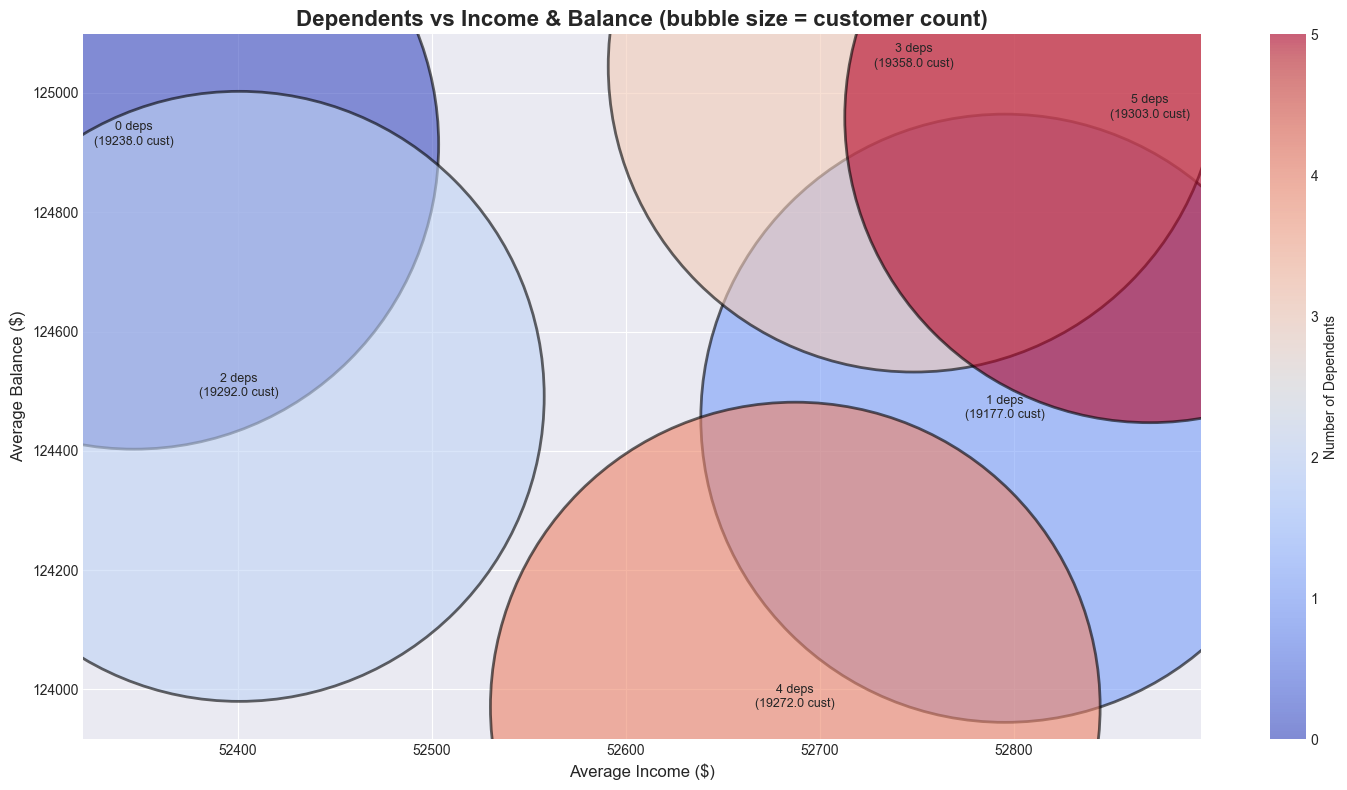

In [39]:
# ============================================================================
# 7. NUMBER OF DEPENDENTS - Bubble chart with income and balance
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 8))

dependents_data = df.groupby('Number of Dependents').agg({
    'Income': 'mean',
    'Balance': 'mean',
    'CustomerId': 'count'
}).reset_index()

scatter = ax.scatter(dependents_data['Income'], 
                     dependents_data['Balance'],
                     s=dependents_data['CustomerId']*10,
                     c=dependents_data['Number of Dependents'],
                     cmap='coolwarm', alpha=0.6, edgecolors='black', linewidth=2)

for i, row in dependents_data.iterrows():
    ax.annotate(f"{int(row['Number of Dependents'])} deps\n({row['CustomerId']} cust)", 
                (row['Income'], row['Balance']),
                fontsize=9, ha='center')

ax.set_xlabel('Average Income ($)', fontsize=12)
ax.set_ylabel('Average Balance ($)', fontsize=12)
ax.set_title('Dependents vs Income & Balance (bubble size = customer count)', 
             fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Number of Dependents')
plt.tight_layout()
plt.show()

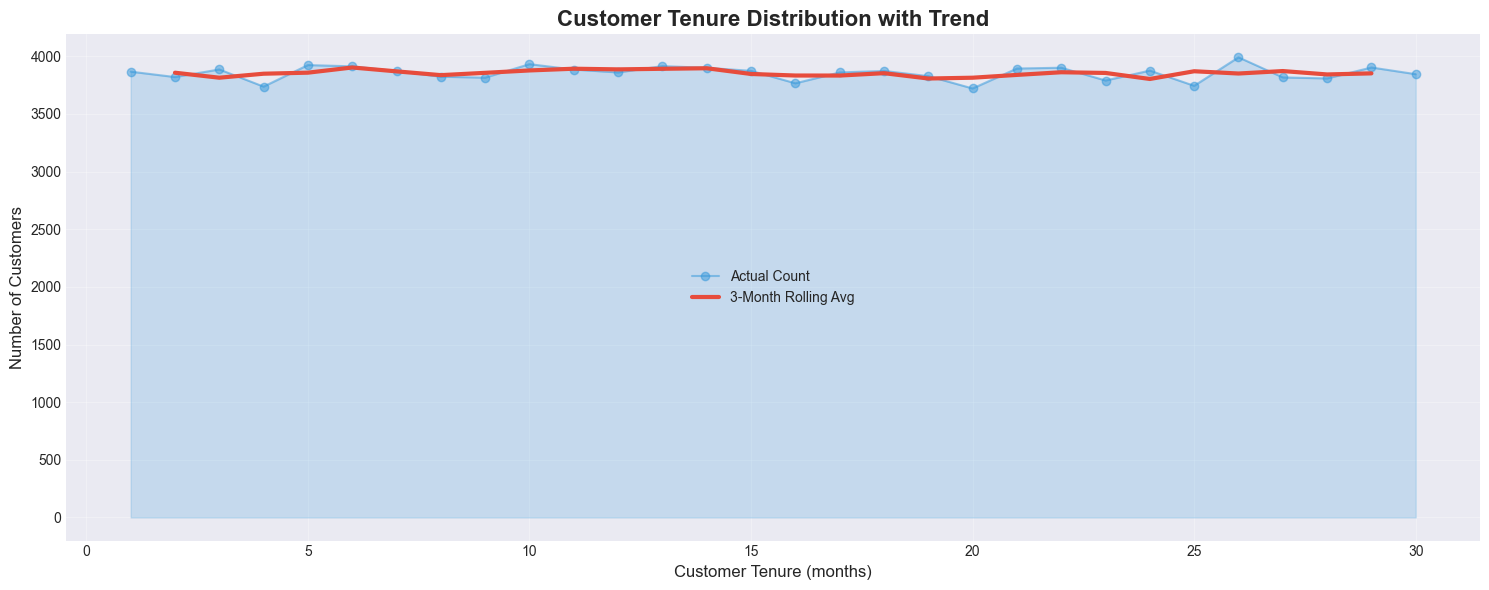

In [40]:
# ============================================================================
# 8. CUSTOMER TENURE - Line chart with rolling average
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 6))

tenure_counts = df['Customer Tenure'].value_counts().sort_index()
rolling_avg = tenure_counts.rolling(window=3, center=True).mean()

ax.plot(tenure_counts.index, tenure_counts.values, 'o-', 
        label='Actual Count', alpha=0.5, color='#3498DB')
ax.plot(rolling_avg.index, rolling_avg.values, 
        linewidth=3, label='3-Month Rolling Avg', color='#E74C3C')
ax.fill_between(tenure_counts.index, tenure_counts.values, alpha=0.2, color='#3498DB')

ax.set_xlabel('Customer Tenure (months)', fontsize=12)
ax.set_ylabel('Number of Customers', fontsize=12)
ax.set_title('Customer Tenure Distribution with Trend', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

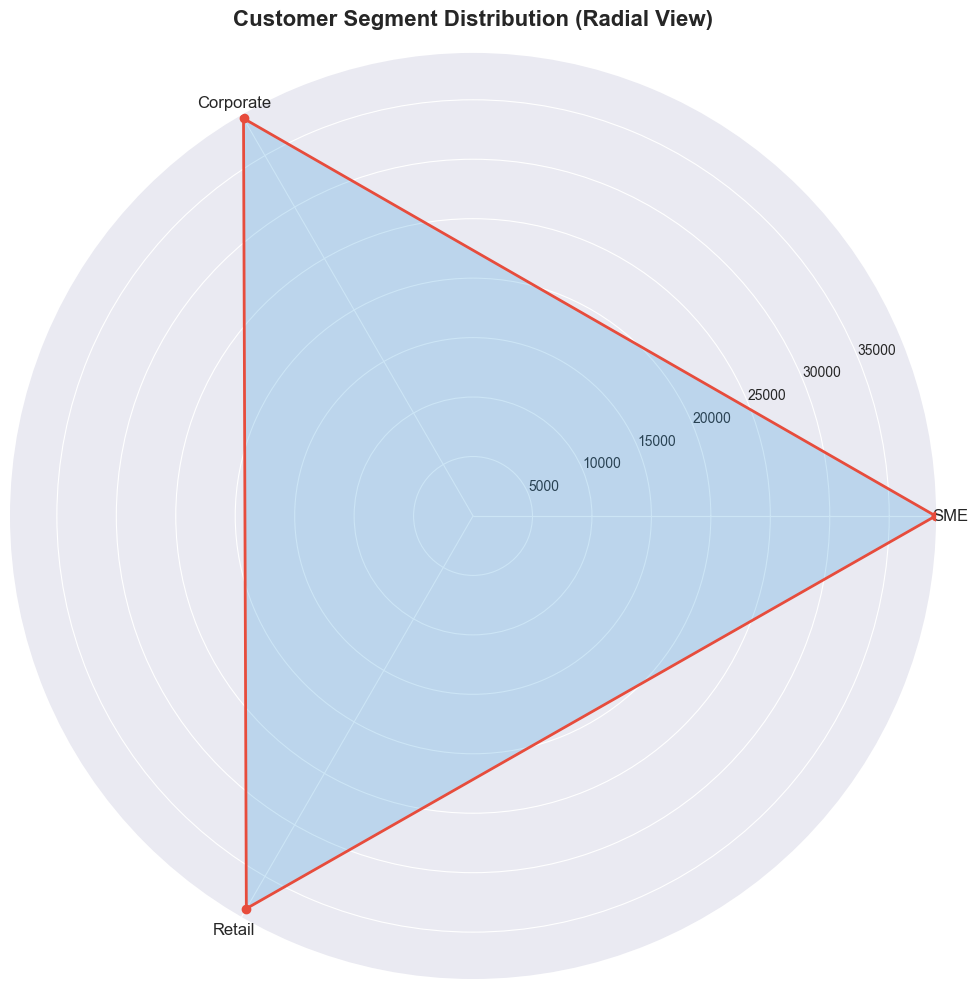

In [41]:
# ============================================================================
# 9. CUSTOMER SEGMENT - Radial/Polar chart
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

segments = df['Customer Segment'].value_counts()
angles = np.linspace(0, 2 * np.pi, len(segments), endpoint=False).tolist()
values = segments.values.tolist()

# Close the plot
angles += angles[:1]
values += values[:1]

ax.plot(angles, values, 'o-', linewidth=2, color='#E74C3C')
ax.fill(angles, values, alpha=0.25, color='#3498DB')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(segments.index, fontsize=12)
ax.set_title('Customer Segment Distribution (Radial View)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True)
plt.tight_layout()
plt.show()

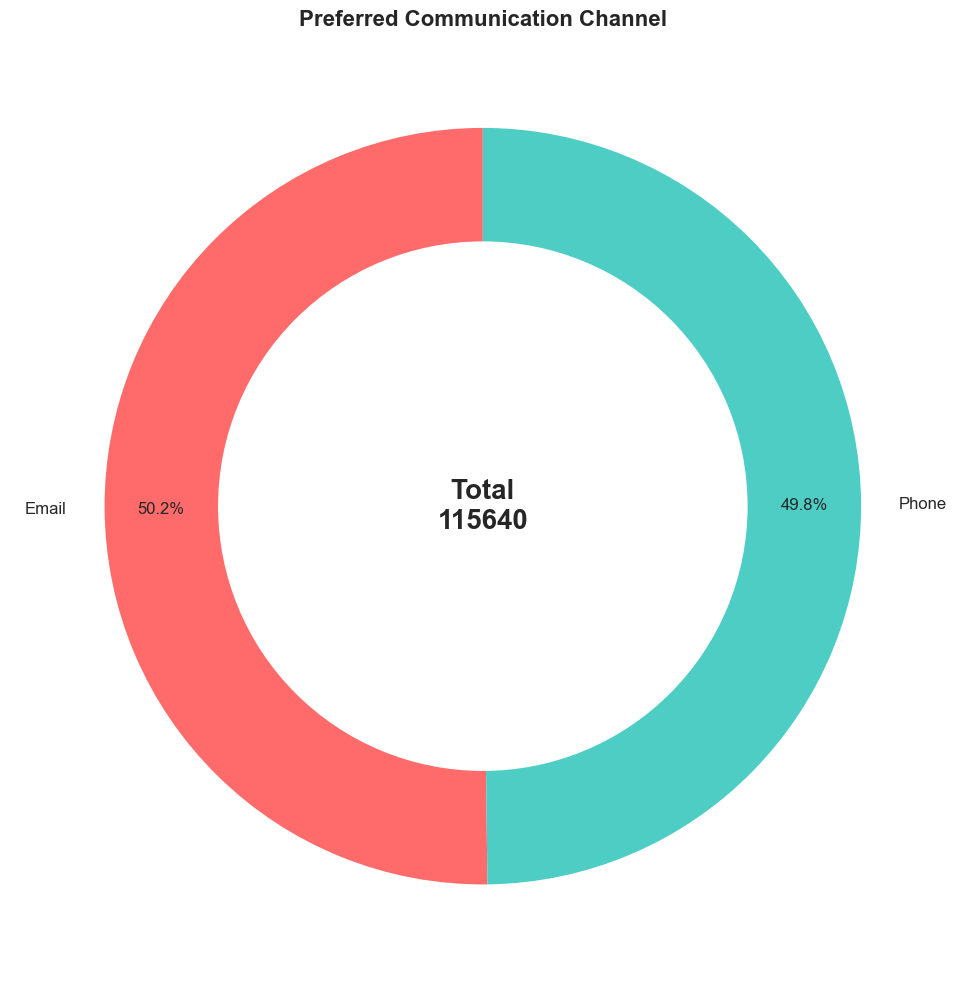

In [42]:
# ============================================================================
# 10. PREFERRED COMMUNICATION CHANNEL - Donut chart
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 10))

comm_channel = df['Preferred Communication Channel'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

wedges, texts, autotexts = ax.pie(comm_channel.values, labels=comm_channel.index,
                                    autopct='%1.1f%%', colors=colors, startangle=90,
                                    pctdistance=0.85, textprops={'fontsize': 12})

# Draw circle for donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax.add_artist(centre_circle)

ax.text(0, 0, f'Total\n{len(df)}', ha='center', va='center', 
        fontsize=20, fontweight='bold')
ax.set_title('Preferred Communication Channel', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

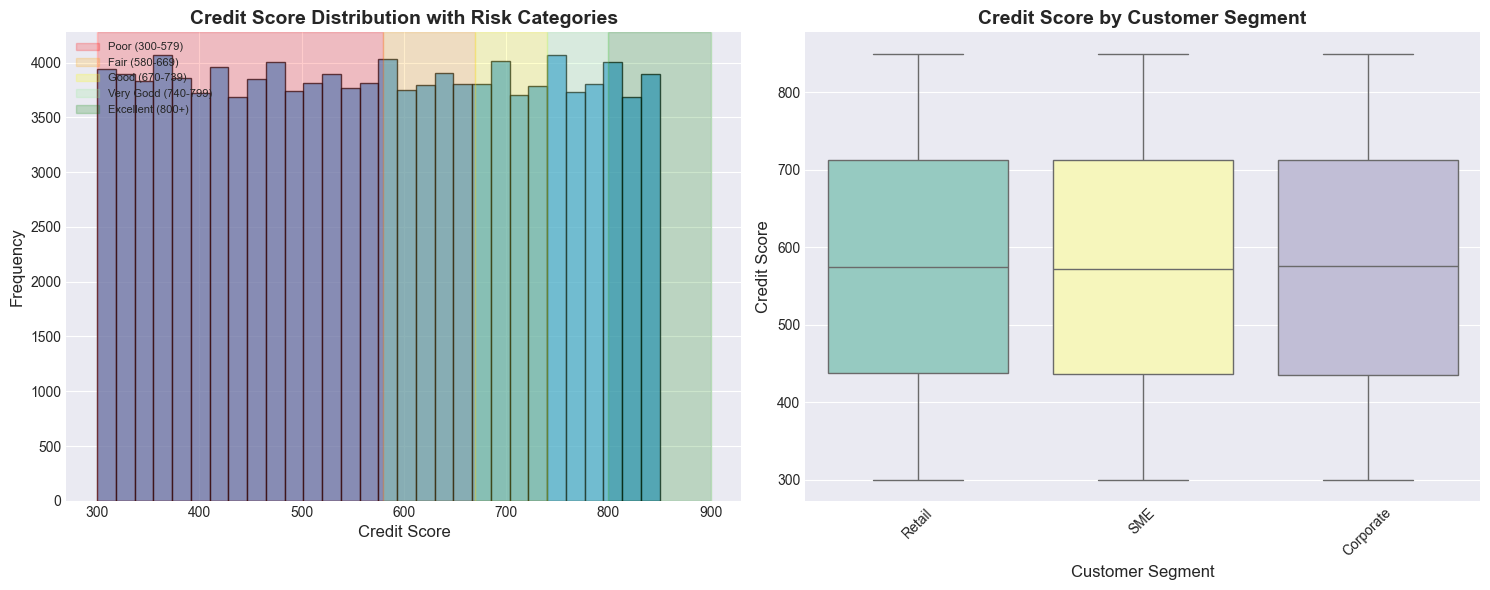

In [43]:
# ============================================================================
# 11. CREDIT SCORE - Distribution with risk categories
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram with risk zones
ax1.hist(df['Credit Score'], bins=30, color='#3498DB', alpha=0.7, edgecolor='black')
ax1.axvspan(300, 580, alpha=0.2, color='red', label='Poor (300-579)')
ax1.axvspan(580, 670, alpha=0.2, color='orange', label='Fair (580-669)')
ax1.axvspan(670, 740, alpha=0.2, color='yellow', label='Good (670-739)')
ax1.axvspan(740, 800, alpha=0.2, color='lightgreen', label='Very Good (740-799)')
ax1.axvspan(800, 900, alpha=0.2, color='green', label='Excellent (800+)')
ax1.set_xlabel('Credit Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Credit Score Distribution with Risk Categories', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8)

# Box plot by segment
sns.boxplot(data=df, x='Customer Segment', y='Credit Score', 
            palette='Set3', ax=ax2)
ax2.set_title('Credit Score by Customer Segment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Customer Segment', fontsize=12)
ax2.set_ylabel('Credit Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

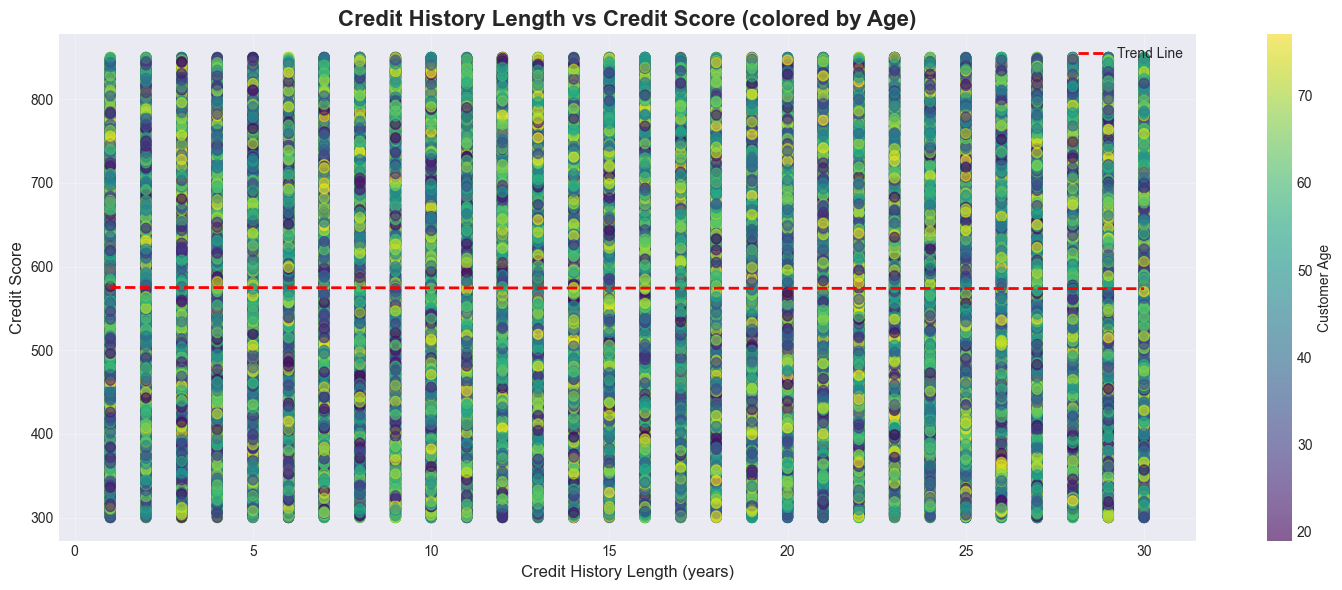

In [44]:
# ============================================================================
# 12. CREDIT HISTORY LENGTH - Scatter with regression
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 6))

scatter = ax.scatter(df['Credit History Length'], df['Credit Score'], 
                     c=df['Age'], cmap='viridis', alpha=0.6, s=50)

# Add regression line
z = np.polyfit(df['Credit History Length'], df['Credit Score'], 1)
p = np.poly1d(z)
ax.plot(df['Credit History Length'].sort_values(), 
        p(df['Credit History Length'].sort_values()), 
        "r--", linewidth=2, label='Trend Line')

ax.set_xlabel('Credit History Length (years)', fontsize=12)
ax.set_ylabel('Credit Score', fontsize=12)
ax.set_title('Credit History Length vs Credit Score (colored by Age)', 
             fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Customer Age')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

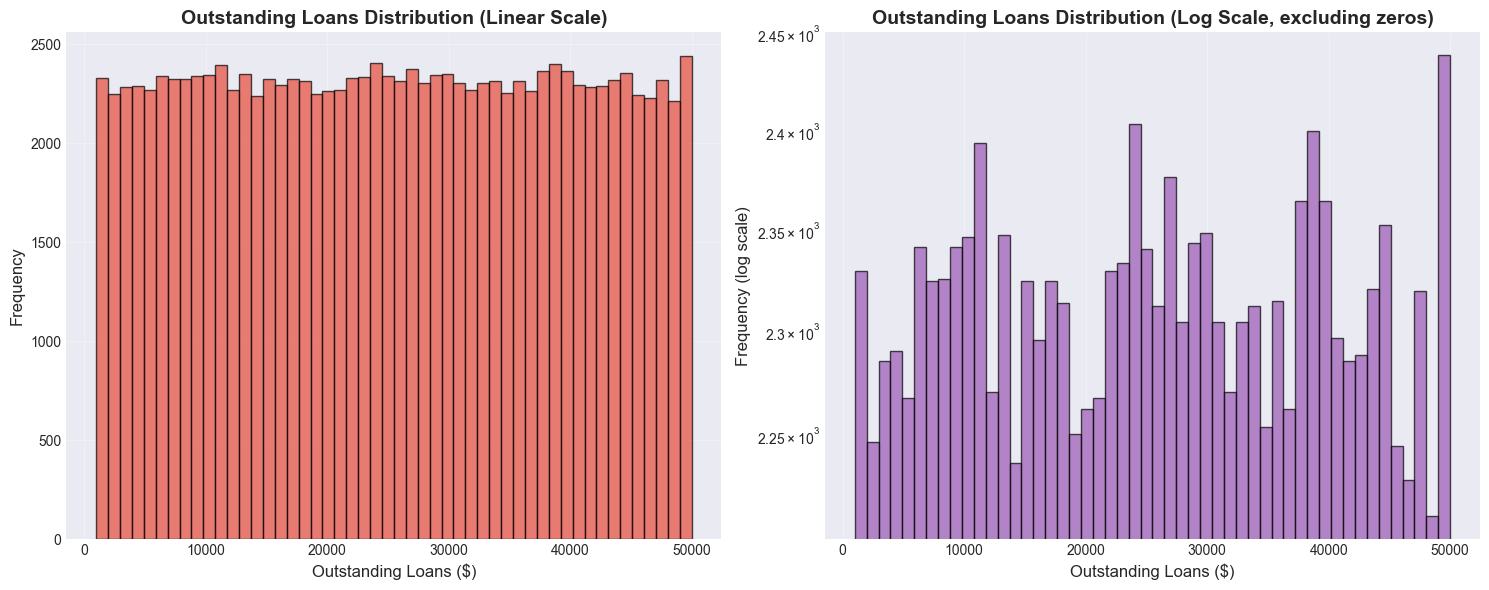

In [45]:
# ============================================================================
# 13. OUTSTANDING LOANS - Histogram with log scale option
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(df['Outstanding Loans'], bins=50, color='#E74C3C', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Outstanding Loans ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Outstanding Loans Distribution (Linear Scale)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Log scale
loans_nonzero = df[df['Outstanding Loans'] > 0]['Outstanding Loans']
ax2.hist(loans_nonzero, bins=50, color='#9B59B6', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Outstanding Loans ($)', fontsize=12)
ax2.set_ylabel('Frequency (log scale)', fontsize=12)
ax2.set_yscale('log')
ax2.set_title('Outstanding Loans Distribution (Log Scale, excluding zeros)', 
              fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

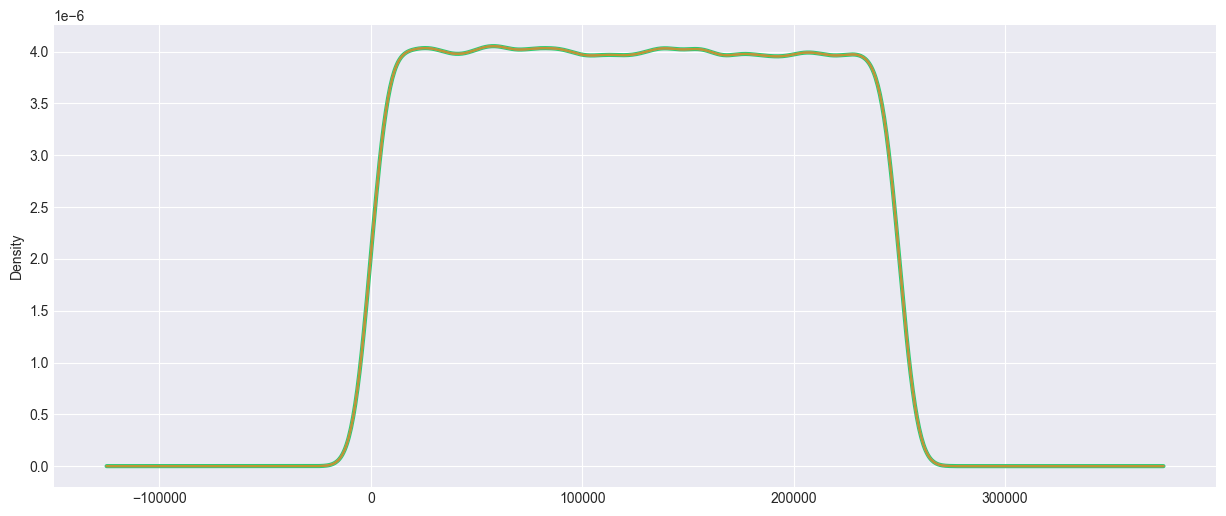

In [ ]:
# DOESNT WORK
# ============================================================================
# 14. BALANCE - KDE plot with quartile markers
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 6))

df['Balance'].plot(kind='kde', ax=ax, linewidth=3, color='#2ECC71')
ax.fill_between(df['Balance'].sort_values(), 0, 
                df['Balance'].sort_values().apply(lambda x: 
                df['Balance'].plot(kind='kde').get_lines()[0].get_ydata()[
                    np.argmin(np.abs(df['Balance'].plot(kind='kde').get_lines()[0].get_xdata() - x))
                ] if len(df['Balance'].plot(kind='kde').get_lines()) > 0 else 0),
                alpha=0.3, color='#2ECC71')

# Add quartile lines
quartiles = df['Balance'].quantile([0.25, 0.5, 0.75])
colors_q = ['blue', 'red', 'blue']
for i, (q, color) in enumerate(zip(quartiles, colors_q)):
    ax.axvline(q, color=color, linestyle='--', linewidth=2, 
               label=f'Q{i+1}: ${q:,.0f}')

ax.set_xlabel('Balance ($)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Account Balance Distribution with Quartiles', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

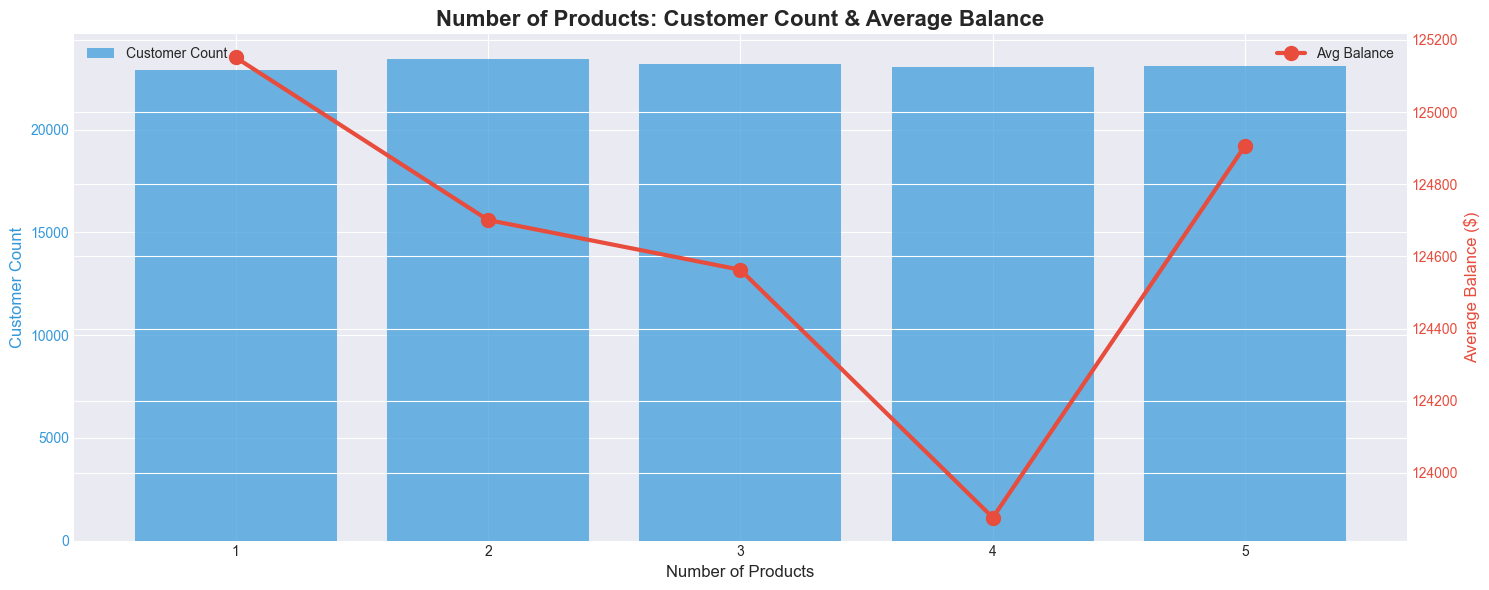

In [48]:
# ============================================================================
# 15. NUMBER OF PRODUCTS - Bar chart with average balance overlay
# ============================================================================
fig, ax1 = plt.subplots(figsize=(15, 6))

products_data = df.groupby('NumOfProducts').agg({
    'CustomerId': 'count',
    'Balance': 'mean'
}).round(2)

ax1.bar(products_data.index, products_data['CustomerId'], 
        color='#3498DB', alpha=0.7, label='Customer Count')
ax1.set_xlabel('Number of Products', fontsize=12)
ax1.set_ylabel('Customer Count', fontsize=12, color='#3498DB')
ax1.tick_params(axis='y', labelcolor='#3498DB')

ax2 = ax1.twinx()
ax2.plot(products_data.index, products_data['Balance'], 
         color='#E74C3C', marker='o', linewidth=3, markersize=10, 
         label='Avg Balance')
ax2.set_ylabel('Average Balance ($)', fontsize=12, color='#E74C3C')
ax2.tick_params(axis='y', labelcolor='#E74C3C')

ax1.set_title('Number of Products: Customer Count & Average Balance', 
              fontsize=16, fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


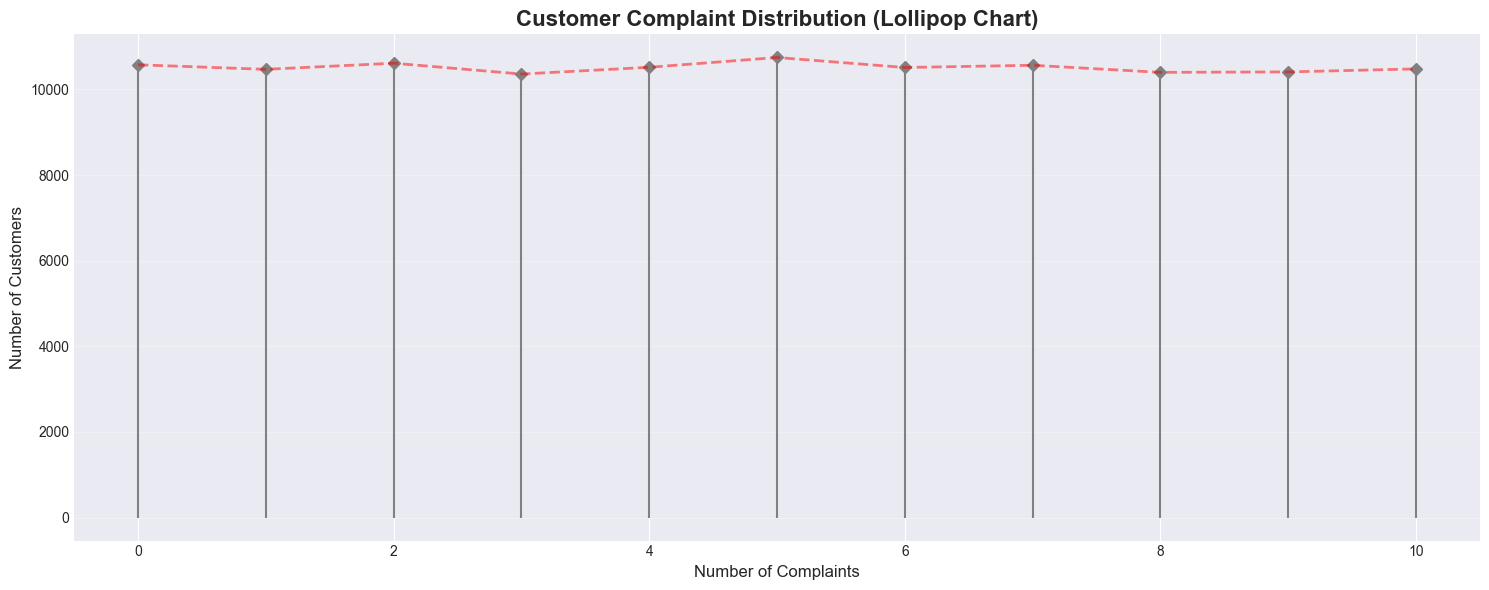

In [49]:
# ============================================================================
# 16. NUMBER OF COMPLAINTS - Lollipop chart
# ============================================================================
fig, ax = plt.subplots(figsize=(15, 6))

complaints_data = df['NumComplaints'].value_counts().sort_index()

ax.stem(complaints_data.index, complaints_data.values, 
        linefmt='grey', markerfmt='D', basefmt=" ")
ax.plot(complaints_data.index, complaints_data.values, 
        'r--', alpha=0.5, linewidth=2)

ax.set_xlabel('Number of Complaints', fontsize=12)
ax.set_ylabel('Number of Customers', fontsize=12)
ax.set_title('Customer Complaint Distribution (Lollipop Chart)', 
             fontsize=16, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

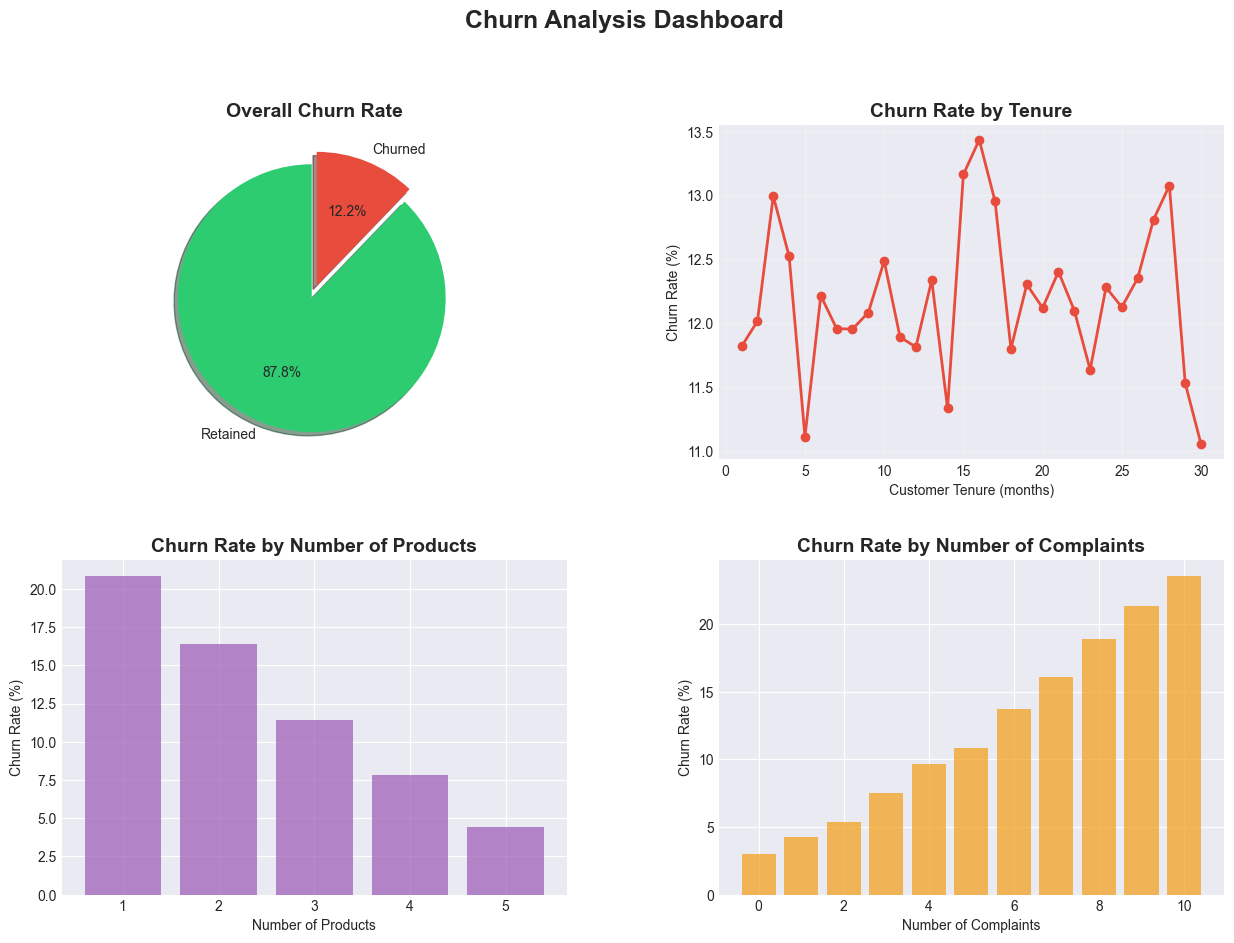

In [50]:
# ============================================================================
# 17. CHURN FLAG - Comparison dashboard
# ============================================================================
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Churn rate pie
ax1 = fig.add_subplot(gs[0, 0])
churn_counts = df['Churn Flag'].value_counts()
colors_churn = ['#2ECC71', '#E74C3C']
ax1.pie(churn_counts.values, labels=['Retained', 'Churned'], 
        autopct='%1.1f%%', colors=colors_churn, startangle=90, 
        explode=(0.05, 0.05), shadow=True)
ax1.set_title('Overall Churn Rate', fontsize=14, fontweight='bold')

# Churn by tenure
ax2 = fig.add_subplot(gs[0, 1])
churn_tenure = df.groupby('Customer Tenure')['Churn Flag'].mean() * 100
ax2.plot(churn_tenure.index, churn_tenure.values, linewidth=2, 
         marker='o', color='#E74C3C')
ax2.set_xlabel('Customer Tenure (months)', fontsize=10)
ax2.set_ylabel('Churn Rate (%)', fontsize=10)
ax2.set_title('Churn Rate by Tenure', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

# Churn by products
ax3 = fig.add_subplot(gs[1, 0])
churn_products = df.groupby('NumOfProducts')['Churn Flag'].agg(['mean', 'count'])
churn_products['mean'] *= 100
ax3.bar(churn_products.index, churn_products['mean'], 
        color='#9B59B6', alpha=0.7)
ax3.set_xlabel('Number of Products', fontsize=10)
ax3.set_ylabel('Churn Rate (%)', fontsize=10)
ax3.set_title('Churn Rate by Number of Products', fontsize=14, fontweight='bold')

# Churn by complaints
ax4 = fig.add_subplot(gs[1, 1])
churn_complaints = df.groupby('NumComplaints')['Churn Flag'].mean() * 100
ax4.bar(churn_complaints.index, churn_complaints.values, 
        color='#F39C12', alpha=0.7)
ax4.set_xlabel('Number of Complaints', fontsize=10)
ax4.set_ylabel('Churn Rate (%)', fontsize=10)
ax4.set_title('Churn Rate by Number of Complaints', fontsize=14, fontweight='bold')

plt.suptitle('Churn Analysis Dashboard', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

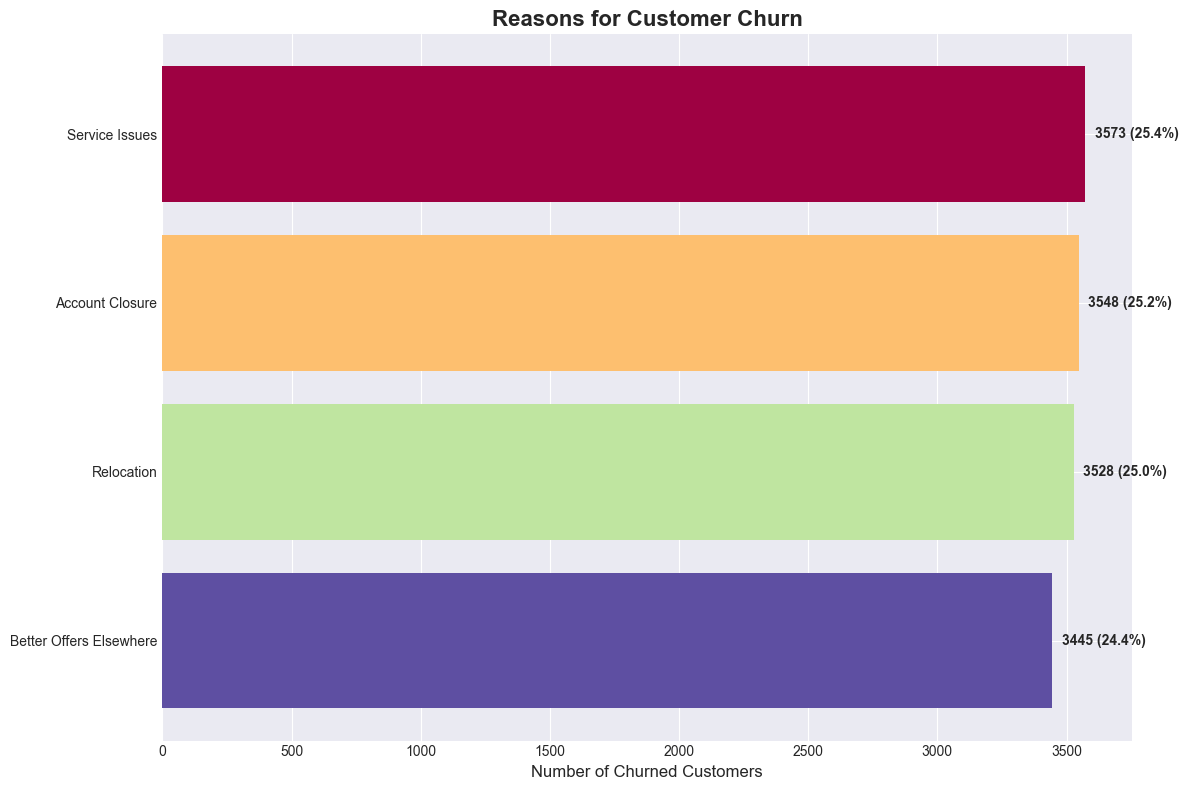


ALL VISUALIZATIONS COMPLETED SUCCESSFULLY!


In [51]:
# ============================================================================
# 18. CHURN REASON - Horizontal bar with percentages
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 8))

churn_reasons = df[df['Churn Flag'] == 1]['Churn Reason'].value_counts()
colors_reasons = plt.cm.Spectral(np.linspace(0, 1, len(churn_reasons)))

bars = ax.barh(churn_reasons.index, churn_reasons.values, color=colors_reasons)
ax.set_xlabel('Number of Churned Customers', fontsize=12)
ax.set_title('Reasons for Customer Churn', fontsize=16, fontweight='bold')
ax.invert_yaxis()

total_churned = churn_reasons.sum()
for i, (v, reason) in enumerate(zip(churn_reasons.values, churn_reasons.index)):
    percentage = (v / total_churned) * 100
    ax.text(v + max(churn_reasons.values)*0.01, i, 
            f'{v} ({percentage:.1f}%)', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ALL VISUALIZATIONS COMPLETED SUCCESSFULLY!")
print("="*80)

10. MATRICE DE CORRÉLATION

In [52]:
# Sélection des variables numériques pertinentes
numeric_cols = ['Number of Dependents', 'Income', 'Customer Tenure', 'Credit Score', 'Credit History Length',
                'Outstanding Loans', 'Balance', 'NumOfProducts', 'NumComplaints', 'Churn Flag']
correlation_matrix = df[numeric_cols].corr()

In [53]:
print("Corrélations avec la variable cible 'Churn Flag':")

churn_correlations = correlation_matrix['Churn Flag'].sort_values(ascending=False)
print(churn_correlations)

Corrélations avec la variable cible 'Churn Flag':
Churn Flag               1.000000
NumComplaints            0.204626
Number of Dependents     0.003109
Credit History Length    0.002899
Income                   0.002286
Customer Tenure          0.000344
Outstanding Loans       -0.001146
NumOfProducts           -0.179083
Credit Score            -0.182802
Balance                 -0.499981
Name: Churn Flag, dtype: float64


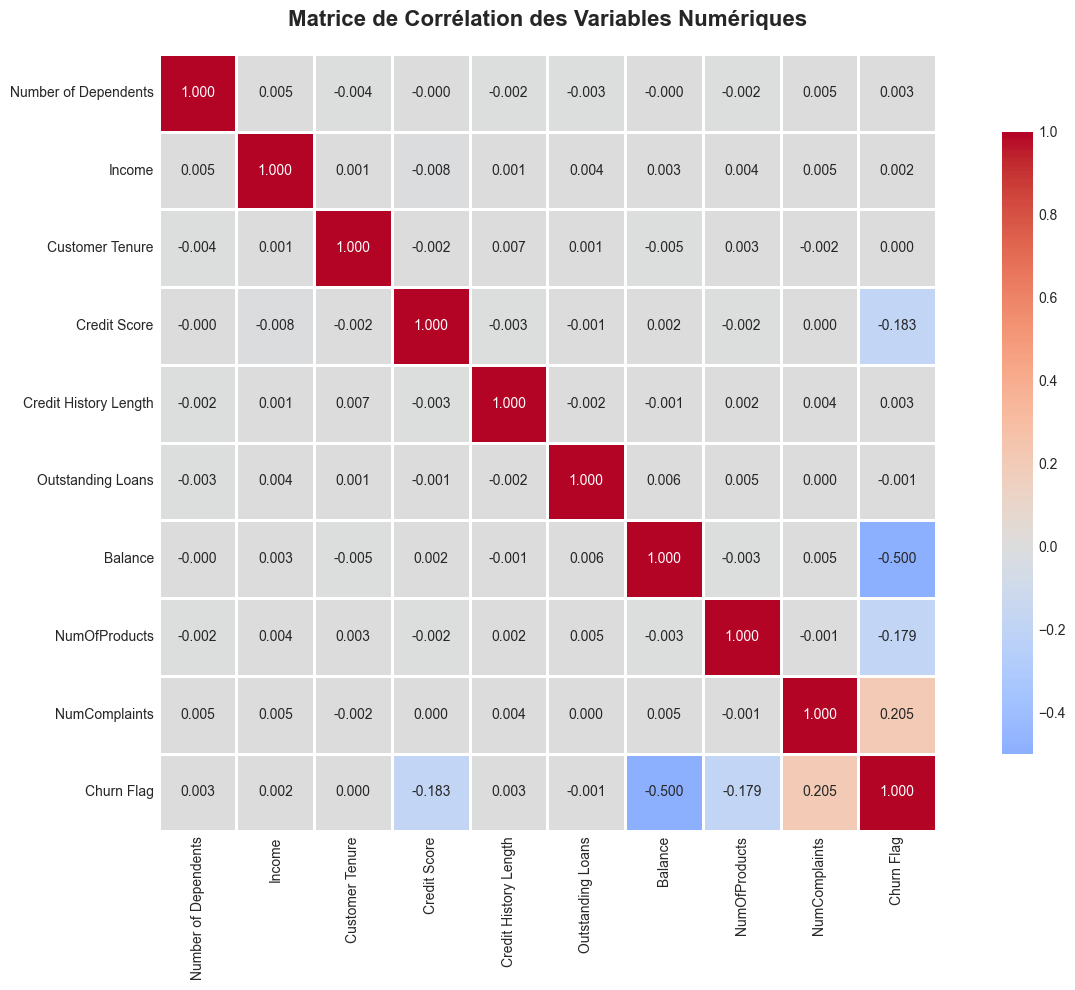

In [54]:
# Visualisation de la matrice de corrélation
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Variables Numériques', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./png/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()